In [1]:
'''
If you are running locally then 
1. reboot your local machine
2. create an environment called 'colab' using anaconda prompt
if you have a gpu
conda create -n colab python tensorflow-gpu 
if not 
conda create -n colab python tensorflow
3. to install jupyter notebook
conda install jupyter notebook
4. to go to the 'colab' environment
activate colab
5. change file path to locate this notebook and then type 'jupyter notebook'

If you use colab
1. save the data file in your google drive
2. goto colab and start running the code
'''

"\nIf you are running locally then \n1. reboot your local machine\n2. create an environment called 'colab' using anaconda prompt\nif you have a gpu\nconda create -n colab python tensorflow-gpu \nif not \nconda create -n colab python tensorflow\n3. to install jupyter notebook\nconda install jupyter notebook\n4. to go to the 'colab' environment\nactivate colab\n5. change file path to locate this notebook and then type 'jupyter notebook'\n\nIf you use colab\n1. save the data file in your google drive\n2. goto colab and start running the code\n"

In [2]:
#install prominent libraries with specific versions
#!pip install tensorflow==2.0.0
#!pip install keras==2.2.4-tf
#!pip install pandas==1.0.5
#!pip install sklearn==0.23.1
#!pip install matplotlib==3.2.2
#!pip install hyperas
#!pip install hyperopt

In [3]:
from __future__ import print_function
import pandas as pd
import numpy as np
import os
import random
import pickle
import tensorflow as tf
#from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, CuDNNLSTM, CuDNNGRU, Input, Activation, Flatten, BatchNormalization, Reshape, Bidirectional
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard, History, ReduceLROnPlateau
from tensorflow.python.keras.models import Model, load_model, clone_model, save_model
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras import regularizers
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt
from matplotlib import style
from tensorflow.python.keras.optimizers import SGD, RMSprop, Adam, Adadelta
from tensorflow.python.keras.utils import np_utils
from sklearn.preprocessing import *
import datetime
from tqdm import tqdm
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.layers import Dense, Input, LSTM, Bidirectional, Activation, Conv1D, GRU, TimeDistributed
from tensorflow.python.keras.layers import Dropout, Embedding, GlobalMaxPooling1D, MaxPooling1D, Add, Flatten, SpatialDropout1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D, BatchNormalization, concatenate
from tensorflow.python.keras.layers import Reshape, merge, Concatenate, Lambda, Average
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import initializers, regularizers, constraints
from tensorflow.python.keras.initializers import *
import hyperas
import hyperopt
from hyperas.distributions import choice, uniform
from hyperas import optim
from hyperopt import Trials, STATUS_OK, tpe, rand
from sklearn.metrics import confusion_matrix, roc_auc_score
import itertools
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
import pandas_market_calendars as mcal 
import datetime 
from datetime import timedelta  
import yfinance as yf
import glob 

C:\Users\kenneth\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\kenneth\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\kenneth\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\kenneth\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\f

In [4]:
#Get library versions
print("tensorflow.__version__ = ", tf.__version__)
# import tensorflow.python.keras
# print("keras.__version__ = ", tensorflow.python.keras.__version__)
import sklearn 
print("sklearn.__version__ = ", sklearn.__version__)
print("numpy.__version__ = ", np.__version__)
print("pandas.__version__ = ", pd.__version__)
import matplotlib
print("matplotlib.__version__ = ", matplotlib.__version__)
now = datetime.datetime.now()
print ("Last run date : ", now.strftime("%m-%d-%Y"))

tensorflow.__version__ =  1.10.0
sklearn.__version__ =  0.21.3
numpy.__version__ =  1.17.0
pandas.__version__ =  1.0.1
matplotlib.__version__ =  3.1.3
Last run date :  07-31-2020


In [5]:
'''
*****************************************************
please make sure the model_name is the same as the notebook
*****************************************************
'''
model_name = '5.18_Multi_Attention_CNN2D_Bidirectional_CUDNNLSTM_3multi_input' # For hyperas, it is the notebook name (make sure the notebook resides in google drive if using colab)
max_evals = 5 # number of hyperas evaluations for finding hyperparameters. More choices will require to higher evaluations
early_stopping_count= 100 # stop training run if there is no improvement in accuracy after the choosen epoch count
training_epochs=100 # Note: hyperas epochs are different from training epochs
val_accuracy ='val_acc'  # change it to 'val_accuracy' for tensorflow 2.0 and above.
accuracy = 'acc' # change it to 'accuracy' for tensorflow 2.0 and above.
training_verbose = False #choice 0, 1, 2 or False
checkpointer_verbose = 2 #choice 0, 1, 2 or False
call_reduce_verbose = 1 #choice 0, 1, 2 or False

In [6]:
# change data parameters to improve accuracy
def data_params():
    """
    Function passes global data parameters to hyperas optim.minimize method.
    Please make ensure __pycache__ in your folder and and temp_model.py files are deleted 
    manually if you are making changes to these parameters
    """
    train_size = 0.85  # train and test data split between (0.7 to 0.9),make sure test is atleast of one batch_size
    batch_size=512   # batch_size for training and evaluation
    time_steps = 28   # Number of time steps to create in the dataset
    rm_window =30     # Number of addtional rolling mean columns for choosen ticker price
    hyperas_epochs = 10  # number of epochs for each trails during hypears evaluation
    forecast_period = 7 # can be 1 to 7 in the 7day model
    '''
    ***********************************************************************************
    check to see if using 'RobustScaler','Normalizer', 'MinMaxScaler', 'MaxAbsScaler', 
    'PowerTransformer', 'QuantileTransformer' instead of 'StandardScaler' improves accuracy
    ***********************************************************************************
    '''
    x_scaler=RobustScaler() # change the method to improve accuracy
    
    return train_size, batch_size, time_steps, rm_window, hyperas_epochs, forecast_period, x_scaler

In [7]:
#random seed to generate reproduceable results
from numpy.random import seed
seed(56)
try:
    tf.compat.v1.set_random_seed(56)
except:
    from tensorflow import set_random_seed
    set_random_seed(56)
random.seed(56)
os.environ['PYTHONHASHSEED']=str(1)
os.environ['TF_KERAS'] = '1'

In [8]:
# create these folders if they do not exist
def build_path(dirName):
    try:
        os.makedirs(dirName)    
        print("Directory " , dirName ,  " created ")
    except:
        print("Directory " , dirName ,  " already exists")  

In [9]:
# to check if GPU is getting used locally.....you need to see CPU as well as GPU in the output
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4275432886052030532
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7139449242
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12874225360217897850
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [10]:
def feature_selection():
    '''
    Function reads the dataset and prepares inputs and labels
    '''
    ticker = '^GSPC'  # ticker to classify
    stocks = ['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABMD', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADS', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AGN', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ARNC', 'ATO', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AZO', 'BA', 'BAC', 'BAX', 'BBY', 'BDX', 'BEN', 'BF-B', 'BIIB', 'BK', 'BKNG', 'BKR', 'BLK', 'BLL', 'BMY', 'BR', 'BRK-B', 'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDNS', 'CDW', 'CE', 'CERN', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COO', 'COP', 'COST', 'COTY', 'CPB', 'CPRI', 'CPRT', 'CRM', 'CSCO', 'CSX', 'CTAS', 'CTL', 'CTSH', 'CTVA', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIA', 'DIS', 'DISCA', 'DISCK', 'DISH', 'DLR', 'DLTR', 'DOV', 'DOW', 'DRE', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'DX-Y.NYB', 'DXC', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'EQIX', 'EQR', 'ES', 'ESS', 'ETFC', 'ETN', 'ETR', 'EVRG', 'EW', 'EXC', 'EXPD', 'EXPE', 'EXR', 'F', 'FANG', 'FAST', 'FB', 'FBHS', 'FCX', 'FDX', 'FE', 'FFIV', 'FIS', 'FISV', 'FITB', 'FLIR', 'FLS', 'FLT', 'FMC', 'FOX', 'FOXA', 'FRC', 'FRT', 'FTI', 'FTNT', 'FTV', 'GD', 'GE', 'GILD', 'GIS', 'GL', 'GLW', 'GM', 'GOOG', 'GPC', 'GPN', 'GPS', 'GRMN', 'GS', 'GWW', 'HAL', 'HAS', 'HBAN', 'HBI', 'HCA', 'HD', 'HES', 'HFC', 'HIG', 'HII', 'HLT', 'HOG', 'HOLX', 'HON', 'HP', 'HPE', 'HPQ', 'HRB', 'HRL', 'HSIC', 'HST', 'HSY', 'HUM', 'IBM', 'ICE', 'IDXX', 'IEX', 'IFF', 'ILMN', 'INCY', 'INFO', 'INTC', 'INTU', 'IP', 'IPG', 'IPGP', 'IQV', 'IR', 'IRM', 'ISRG', 'IT', 'ITW', 'IVZ', 'J', 'JBHT', 'JCI', 'JKHY', 'JNJ', 'JNPR', 'JPM', 'JWN', 'K', 'KEY', 'KEYS', 'KHC', 'KIM', 'KLAC', 'KMB', 'KMI', 'KMX', 'KO', 'KR', 'KSS', 'KSU', 'L', 'LB', 'LDOS', 'LEG', 'LEN', 'LH', 'LHX', 'LIN', 'LKQ', 'LLY', 'LMT', 'LNC', 'LNT', 'LOW', 'LRCX', 'LUV', 'LVS', 'LW', 'LYB', 'LYV', 'M', 'MA', 'MAA', 'MAR', 'MAS', 'MCD', 'MCHP', 'MCK', 'MCO', 'MDLZ', 'MDT', 'MET', 'MGM', 'MHK', 'MKC', 'MKTX', 'MLM', 'MMC', 'MMM', 'MNST', 'MO', 'MOS', 'MPC', 'MRK', 'MRO', 'MS', 'MSCI', 'MSFT', 'MSI', 'MTB', 'MTD', 'MU', 'MXIM', 'MYL', 'NBL', 'NCLH', 'NDAQ', 'NEE', 'NEM', 'NFLX', 'NI', 'NKE', 'NLOK', 'NLSN', 'NOC', 'NOV', 'NOW', 'NRG', 'NSC', 'NTAP', 'NTRS', 'NUE', 'NVDA', 'NVR', 'NWL', 'NWS', 'NWSA', 'O', 'ODFL', 'OKE', 'OMC', 'ORCL', 'ORLY', 'OXY', 'PAYX', 'PBCT', 'PCAR', 'PEAK', 'PEG', 'PEP', 'PFE', 'PFG', 'PG', 'PGR', 'PH', 'PHM', 'PKG', 'PKI', 'PLD', 'PM', 'PNC', 'PNR', 'PNW', 'PPG', 'PPL', 'PRGO', 'PRU', 'PSA', 'PSX', 'PVH', 'PWR', 'PXD', 'PYPL', 'QCOM', 'QRVO', 'RCL', 'RE', 'REG', 'REGN', 'RF', 'RHI', 'RJF', 'RL', 'RMD', 'ROK', 'ROL', 'ROP', 'ROST', 'RSG', 'RTN', 'SBAC', 'SBUX', 'SCHW', 'SEE', 'SHW', 'SIVB', 'SJM', 'SLB', 'SLG', 'SNA', 'SNPS', 'SO', 'SPG', 'SPGI', 'SPY', 'SRE', 'STE', 'STT', 'STX', 'STZ', 'SWK', 'SWKS', 'SYF', 'SYK', 'SYY', 'T', 'TAP', 'TDG', 'TEL', 'TFC', 'TFX', 'TGT', 'TIF', 'TJX', 'TMO', 'TMUS', 'TPR', 'TROW', 'TRV', 'TSCO', 'TSN', 'TTWO', 'TWTR', 'TXN', 'TXT', 'UA', 'UAA', 'UAL', 'UDR', 'UHS', 'ULTA', 'UNH', 'UNM', 'UNP', 'UPS', 'URI', 'USB', 'UTX', 'V', 'VAR', 'VFC', 'VIAC', 'VLO', 'VMC', 'VNO', 'VRSK', 'VRSN', 'VRTX', 'VTR', 'VZ', 'WAB', 'WAT', 'WBA', 'WCG', 'WDC', 'WEC', 'WELL', 'WFC', 'WHR', 'WLTW', 'WM', 'WMB', 'WMT', 'WRB', 'WRK', 'WU', 'WY', 'WYNN', 'XEC', 'XEL', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLNX', 'XLP', 'XLU', 'XLV', 'XLY', 'XOM', 'XRAY', 'XRT', 'XRX', 'XYL', 'YUM', 'ZBH', 'ZBRA', 'ZION', 'ZTS', '^GSPC', '^IXIC', '^NDX', '^SOX', '^TNX', '^VIX', '^VVIX', '^VXN', '^VXO', '^VXV']
    short_interest = ['Trading Volume']
    nytimes = ['neg', 'neu', 'pos']
    economic = ['Dividend', 'Earnings', 'CPI', 'Long Interest Rate', 'Real Price', 'Real Dividend', 'Real Earnings', 'Cyclically Adjusted PE Ratio', 'ECRI USLEADING LEVEL', 'ECRI USLEADING GROWTH', 'ECRI USLAGGING LEVEL', 'ECRI USLAGGING GROWTH', 'ECRI_USCOIN LEVEL', 'ECRI_USCOIN GROWTH', 'University of Michigan Consumer Survey, Index of Consumer Sentiment', 'Bullish', 'Neutral', 'Bearish', 'Bullish 8-Week Mov Avg', 'Bull-Bear Spread', 'Bullish Average', 'Bullish Average + St. Dev', 'Bullish Average - St. Dev', 'Stock Market Confidence Indices - United States One Year Index Data - Individual', 'Stock Market Confidence Indices - United States One Year Index Data - Institutional', 'Stock Market Confidence Indices - United States Buy on Dips Confidence Index Data - Individual', 'Stock Market Confidence Indices - United States Buy on Dips Confidence Index Data - Institutional', 'Stock Market Confidence Indices - United States Crash Confidence Index Data - Individual', 'Stock Market Confidence Indices - United States Crash Confidence Index Data - Institutional', 'Stock Market Confidence Indices - United States Valuation Index Data - Individual', 'Stock Market Confidence Indices - United States Valuation Index Data - Institutional', 'Zillow Home Value Index (Metro): Zillow Rental Index - All Homes - United States', 'Zillow Home Value Index (Metro): Turnover - All Homes - United States', 'Zillow Home Value Index (Metro): Price To Rent Ratio - All Homes - United States', 'Zillow Home Value Index (Metro): Median Listing Price - All Homes - United States', 'Zillow Home Value Index (Metro):  Home Sold As Foreclosure - Ratio - All Homes - United States', 'Historical Housing Market Data - Real Home Price Index', 'Cost Index', 'U.S. Population (Millions)', 'Long Rate', 'Historical Housing Market Data - Nominal Home Price Index', 'Historical Housing Market Data - Consumer Price Index (Quarterly)', '30-Year Conventional Mortgage Rate', 'House Price Index - US National', '15-Year Fix Rate', '15-Year Fix Rate Fees & Points', '5-Year Adjustable Rate', '5-Year Adjustable Rate Fees & Points', '1-Year Adjustable Rate', '1-Year Adjustable Rate Fees & Points', '30-Year Fixed Rate Mortgage Average in the United States', 'Federal Funds Rate', '90 day T Bill Rate', 'One Year Maturity Treasury Yield', 'Ten Year Maturity Treasury Yield', 'Freddie Mac Commitment Fixed Rate Mortgages', 'Freddie Mac Commitment ARMs', 'Prime Rate', 'Total Housing Starts', 'Single Family Housing Starts', 'Multi-Family Housing Starts', 'New Single-Family Sales', 'Existing Single-Family Home Sales', '1-Year CD: National Rate of Banks', '5-Year CD: National Rate of Banks', 'Interest Checking Accounts: National Rate of Banks', 'Money Market Accounts: National Rate of Banks', '1-Month AA Financial Commercial Paper Rate', '3-Month AA Financial Commercial Paper Rate', '1-Month AA Nonfinancial Commercial Paper Rate', '3-Month AA Nonfinancial Commercial Paper Rate', 'Effective Federal Funds Rate', '10-Year Treasury Inflation-Indexed Security, Constant Maturity', '20-Year Treasury Inflation-Indexed Security, Constant Maturity', '30-Year Treasury Inflation-Indexed Security, Constant Maturity', '5-Year Treasury Inflation-Indexed Security, Constant Maturity', '7-Year Treasury Inflation-Indexed Security, Constant Maturity', '10-Year Treasury Constant Maturity Rate', '2-Year Treasury Constant Maturity Rate', '20-Year Treasury Constant Maturity Rate', '3-Year Treasury Constant Maturity Rate', '30-Year Treasury Constant Maturity Rate', '5-Year Treasury Constant Maturity Rate', '7-Year Treasury Constant Maturity Rate', 'Bank Prime Loan Rate', '1-Year Treasury Bill: Secondary Market Rate', '3-Month Treasury Bill: Secondary Market Rate', '4-Week Treasury Bill: Secondary Market Rate', '6-Month Treasury Bill: Secondary Market Rate', 'Overnight London Interbank Offered Rate (LIBOR), based on U.S. Dollar', 'Finance Rate on Personal Loans at Commercial Banks, 24 Month Loan', 'Commercial Bank Interest Rate on Credit Card Plans, All Accounts', 'RR3_TBILL_PGDP_2', 'RR3_TBILL_PGDP_3', 'RR3_TBILL_PGDP_4', 'RR3_TBILL_PGDP_5', 'RR2_TBILL_CCPI_2', 'RR2_TBILL_CCPI_3', 'RR2_TBILL_CCPI_4', 'RR2_TBILL_CCPI_5', 'Gross domestic product', 'Personal consumption expenditures', ':Goods', '::Durable goods', '::Nondurable goods', ':Services', 'Gross private domestic investment', 'Net exports of goods and services', 'Government consumption expenditures and gross investment', '::Gross domestic income (GDI)', '::Gross national product', '::Gross national income', '::Disposable personal income', 'Personal income', ':Compensation of employees', '::Wages and salaries', ':Population (midperiod; thousands)', '::Disposable personal income; current dollars', 'Services', ':Household consumption expenditures (for services)', '::Housing and utilities', '::Health care', '::Transportation services', '::Recreation services', '::Food services and accommodations', '::Financial services and insurance', '::Other services', 'Corporate profits with inventory valuation and capital consumption adjustments', 'Consumer Price Index - USA', 'United States Gross National Savings, % of GDP', 'United States GDP at Constant Prices, % change', 'Nominal Potential Gross Domestic Product', 'Industrial Production: Durable Goods: Other durable goods', 'FRED: Projection of General government net lending/borrowing for United States', 'FRED: Real Potential Gross Domestic Product', 'FRED: Real Gross Domestic Product', 'FRED: Gross Domestic Product', 'FRBP: GDPplus GDP Growth', 'Inflation YOY - USA', 'Consumer Price Index for All Urban Consumers: All Items', 'PRCCPI1', 'PRCCPI2', 'PRCCPI3', 'PRCCPI4', 'PRCCPI5', 'PRCCPI6', 'PRCCPI7', 'PRCCPI8', 'PRCCPI9', 'PRCCPI10', 'PRCCPI11', 'PRCCPI12', 'PRCCPI13', 'PRCCPI14', 'PRCCPI15', 'PRCCPI16', 'PRCCPI17', 'PRCCPI18', 'PRCCPI19', 'PRCCPI20', 'Mean CPI1', 'Mean CPI2', 'Mean CPI3', 'Mean CPI4', 'Mean CPI5', 'Mean CPI6', 'Mean CPIA', 'Mean CPIB', 'Mean CPIC', 'Median CPI1', 'Median CPI2', 'Median CPI3', 'Median CPI4', 'Median CPI5', 'Median CPI6', 'Median CPIA', 'Median CPIB', 'Median CPIC', 'CORECPI1', 'CORECPI2', 'CORECPI3', 'CORECPI4', 'CORECPI5', 'CORECPI6', 'CORECPIA', 'CORECPIB', 'CORECPIC', 'Median CORECPI1', 'Median CORECPI2', 'Median CORECPI3', 'Median CORECPI4', 'Median CORECPI5', 'Median CORECPI6', 'Median CORECPIA', 'Median CORECPIB', 'Median CORECPIC', 'Employment; Openings; All industries; Rate (Percent) - National', 'Employment; Gross Job Losses; All industries; Rate (Percent) - National', 'Employment - All employees, quarterly averages, seasonally adjusted, thousands; Total nonfarm industry', 'Employment - All employees, thousands; Total private industry', 'Employment - All employees, thousands; Total nonfarm industry', 'Hires for Total nonfarm in Total US Region', 'Layoffs and discharges for Total nonfarm in Total US Region', 'Total separations for Total nonfarm in Total US Region', 'Hires percent for Total private in Total US Region', 'Job openings for Total private in Total US Region', 'Job openings percent for Total private in Total US Region', 'Total separations for Total private in Total US Region', 'Hires for Construction in Total US Region', 'Total separations for Construction in Total US Region', 'Hires for Manufacturing in Total US Region', 'Hires for Government in Total US Region', 'Total separations for Government in Total US Region', 'US Forecast Unemployment Rate, % of Total Labor Force', 'ISM Manufacturing Employment Index', 'ISM Non-Manufacturing Employment Index', 'FRED Forecast Natural Rate of Unemployment (Short-Term)', 'FRED Forecast Natural Rate of Unemployment (Long-Term)', 'ADP_Total private', 'ADP_Goods producing', 'Service providing', 'ADP_Goods Producing Industries_1-19', 'ADP_Goods Producing Industries_20-49', 'ADP_Goods Producing Industries_1-49', 'ADP_Goods Producing Industries_50-499', 'ADP_Goods Producing Industries_500+', 'ADP_Goods Producing Industries_500-999', 'ADP_Goods Producing Industries_1,000+', 'ADP_Construction', 'ADP_Natural resources & mining', 'Manufacturing', 'ADP_Prof.l/business services', 'ADP_Professional services', 'ADP_Total Non-Farm Private_1-19', 'ADP_Total Non-Farm Private_20-49', 'ADP_Total Non-Farm Private_1-49', 'ADP_Total Non-Farm Private_50-499', 'ADP_Total Non-Farm Private_500+', 'ADP_Total Non-Farm Private_500-999', '1000+', 'ADP_Private Service_1-19', 'ADP_Private Service_20-49', 'ADP_Private Service_1-49', 'ADP_Private Service_50-499', 'ADP_Private Service_500+', 'ADP_Private Service_500-999', 'ADP_Private Service_1,000+', 'Hand to Mouth-Manufacturing Buying Policy: Capital Expenditures', 'Average Days-Manufacturing Buying Policy: Capital Expenditures', 'Hand to Mouth-Manufacturing Buying Policy: MRO Supplies', 'Average Days-Manufacturing Buying Policy: MRO Supplies', 'Manufacturing Backlog of Orders Index', "Manufacturing Customers' Inventories Index", 'Manufacturing Supplier Deliveries Index', 'Manufacturing New Export Orders Index', 'Manufacturing Imports Index', 'Manufacturing Inventories Index', 'Manufacturing New Orders Index', 'Manufacturing Prices Index', 'Manufacturing Production Index', 'Non-Manufacturing Backlog of Orders Index', 'Non-Manufacturing Business Activity Index', 'Non-Manufacturing Supplier Deliveries Index', 'Non-Manufacturing New Export Orders Index', 'Non-Manufacturing Imports Index', 'Non-Manufacturing Inventories Index', 'Non-Manufacturing Inventory Sentiment Index', 'Non-Manufacturing New Orders Index', 'NMI Non-Manufacturing Index', 'Non-Manufacturing Prices Index', 'Gold Prices (Daily) - Currency USD', 'Milk, Nonfat dry, Chicago', 'Crude Oil Futures, Continuous Contract #1 (CL1) (Front Month)', 'UK Natural Gas Futures, Continuous Contract', 'Natural Gas (Henry Hub) Physical Futures, Continuous Contract #1 (NG1) (Front Month)', 'STEO price forecast, Monthly', 'US All Grades Conventional Gas Price', 'Copper Prices', 'Aluminum Prices', 'Silver Price: London Fixing', 'Seasonal Factors for the Empire State Manufacturing Survey - Future General Business Conditions - Percent Reporting Increase', 'Empire State Manufacturing Index - Forecasted Inventories - Diffusion Index (Seasonally Adjusted)', 'Seasonal Factors for the Empire State Manufacturing Survey - Current New Orders - Percent Reporting Decrease', 'Seasonal Factors for the Empire State Manufacturing Survey - Current New Orders - Percent Reporting Increase', 'Empire State Manufacturing Index - Forecasted Shipments - Diffusion Index (Seasonally Adjusted)', 'Empire State Manufacturing Index - Forecasted Unfilled Orders - Diffusion Index (Seasonally Adjusted)', 'Philly Fed Seasonally Adjusted Diffusion Indexes - Future New Orders', 'Philly Fed Seasonally Adjusted Diffusion Indexes - Future Shipments', 'Philly Fed Seasonally Adjusted Diffusion Indexes - Future Unfilled Orders', 'Future New Orders;Percent Reporting Increases for FRB - Philadelphia District']
    pattern = ['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'year_1971', 'year_1972', 'year_1973', 'year_1974', 'year_1975', 'year_1976', 'year_1977', 'year_1978', 'year_1979', 'year_1980', 'year_1981', 'year_1982', 'year_1983', 'year_1984', 'year_1985', 'year_1986', 'year_1987', 'year_1988', 'year_1989', 'year_1990', 'year_1991', 'year_1992', 'year_1993', 'year_1994', 'year_1995', 'year_1996', 'year_1997', 'year_1998', 'year_1999', 'year_2000', 'year_2001', 'year_2002', 'year_2003', 'year_2004', 'year_2005', 'year_2006', 'year_2007', 'year_2008', 'year_2009', 'year_2010', 'year_2011', 'year_2012', 'year_2013', 'year_2014', 'year_2015', 'year_2016', 'year_2017', 'year_2018', 'year_2019', 'year_2020', 'quarter_2', 'quarter_3', 'quarter_4', 'days_of_month_2', 'days_of_month_3', 'days_of_month_4', 'days_of_month_5', 'days_of_month_6', 'days_of_month_7', 'days_of_month_8', 'days_of_month_9', 'days_of_month_10', 'days_of_month_11', 'days_of_month_12', 'days_of_month_13', 'days_of_month_14', 'days_of_month_15', 'days_of_month_16', 'days_of_month_17', 'days_of_month_18', 'days_of_month_19', 'days_of_month_20', 'days_of_month_21', 'days_of_month_22', 'days_of_month_23', 'days_of_month_24', 'days_of_month_25', 'days_of_month_26', 'days_of_month_27', 'days_of_month_28', 'days_of_month_29', 'days_of_month_30', 'days_of_month_31', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'early_close']
    derivatives = ['CALLS', 'PUTS', 'TOTAL_PC', 'P/C Ratio']
    fama = ['ff_0.45', 'ff_-0.32', 'ff_-0.08', 'ff_0.009000000000000001', 'ff_-0.67', 'ff_0.0', 'ff_-0.32.1', 'ff_-0.01', 'ff_0.15', 'ff_0.012']
    correlations = ['corr^GSPC_A', 'corr^GSPC_AAL', 'corr^GSPC_AAP', 'corr^GSPC_AAPL', 'corr^GSPC_ABBV', 'corr^GSPC_ABC', 'corr^GSPC_ABMD', 'corr^GSPC_ABT', 'corr^GSPC_ACN', 'corr^GSPC_ADBE', 'corr^GSPC_ADI', 'corr^GSPC_ADM', 'corr^GSPC_ADP', 'corr^GSPC_ADS', 'corr^GSPC_ADSK', 'corr^GSPC_AEE', 'corr^GSPC_AEP', 'corr^GSPC_AES', 'corr^GSPC_AFL', 'corr^GSPC_AGN', 'corr^GSPC_AIG', 'corr^GSPC_AIV', 'corr^GSPC_AIZ', 'corr^GSPC_AJG', 'corr^GSPC_AKAM', 'corr^GSPC_ALB', 'corr^GSPC_ALGN', 'corr^GSPC_ALK', 'corr^GSPC_ALL', 'corr^GSPC_ALLE', 'corr^GSPC_ALXN', 'corr^GSPC_AMAT', 'corr^GSPC_AMCR', 'corr^GSPC_AMD', 'corr^GSPC_AME', 'corr^GSPC_AMG', 'corr^GSPC_AMGN', 'corr^GSPC_AMP', 'corr^GSPC_AMT', 'corr^GSPC_AMZN', 'corr^GSPC_ANET', 'corr^GSPC_ANSS', 'corr^GSPC_ANTM', 'corr^GSPC_AON', 'corr^GSPC_AOS', 'corr^GSPC_APA', 'corr^GSPC_APD', 'corr^GSPC_APH', 'corr^GSPC_APTV', 'corr^GSPC_ARE', 'corr^GSPC_ARNC', 'corr^GSPC_ATO', 'corr^GSPC_ATVI', 'corr^GSPC_AVB', 'corr^GSPC_AVGO', 'corr^GSPC_AVY', 'corr^GSPC_AWK', 'corr^GSPC_AXP', 'corr^GSPC_AZO', 'corr^GSPC_BA', 'corr^GSPC_BAC', 'corr^GSPC_BAX', 'corr^GSPC_BBY', 'corr^GSPC_BDX', 'corr^GSPC_BEN', 'corr^GSPC_BF-B', 'corr^GSPC_BIIB', 'corr^GSPC_BK', 'corr^GSPC_BKNG', 'corr^GSPC_BKR', 'corr^GSPC_BLK', 'corr^GSPC_BLL', 'corr^GSPC_BMY', 'corr^GSPC_BR', 'corr^GSPC_BRK-B', 'corr^GSPC_BSX', 'corr^GSPC_BWA', 'corr^GSPC_BXP', 'corr^GSPC_C', 'corr^GSPC_CAG', 'corr^GSPC_CAH', 'corr^GSPC_CAT', 'corr^GSPC_CB', 'corr^GSPC_CBOE', 'corr^GSPC_CBRE', 'corr^GSPC_CCI', 'corr^GSPC_CCL', 'corr^GSPC_CDNS', 'corr^GSPC_CDW', 'corr^GSPC_CE', 'corr^GSPC_CERN', 'corr^GSPC_CF', 'corr^GSPC_CFG', 'corr^GSPC_CHD', 'corr^GSPC_CHRW', 'corr^GSPC_CHTR', 'corr^GSPC_CI', 'corr^GSPC_CINF', 'corr^GSPC_CL', 'corr^GSPC_CLX', 'corr^GSPC_CMA', 'corr^GSPC_CMCSA', 'corr^GSPC_CME', 'corr^GSPC_CMG', 'corr^GSPC_CMI', 'corr^GSPC_CMS', 'corr^GSPC_CNC', 'corr^GSPC_CNP', 'corr^GSPC_COF', 'corr^GSPC_COG', 'corr^GSPC_COO', 'corr^GSPC_COP', 'corr^GSPC_COST', 'corr^GSPC_COTY', 'corr^GSPC_CPB', 'corr^GSPC_CPRI', 'corr^GSPC_CPRT', 'corr^GSPC_CRM', 'corr^GSPC_CSCO', 'corr^GSPC_CSX', 'corr^GSPC_CTAS', 'corr^GSPC_CTL', 'corr^GSPC_CTSH', 'corr^GSPC_CTVA', 'corr^GSPC_CTXS', 'corr^GSPC_CVS', 'corr^GSPC_CVX', 'corr^GSPC_CXO', 'corr^GSPC_D', 'corr^GSPC_DAL', 'corr^GSPC_DD', 'corr^GSPC_DE', 'corr^GSPC_DFS', 'corr^GSPC_DG', 'corr^GSPC_DGX', 'corr^GSPC_DHI', 'corr^GSPC_DHR', 'corr^GSPC_DIA', 'corr^GSPC_DIS', 'corr^GSPC_DISCA', 'corr^GSPC_DISCK', 'corr^GSPC_DISH', 'corr^GSPC_DLR', 'corr^GSPC_DLTR', 'corr^GSPC_DOV', 'corr^GSPC_DOW', 'corr^GSPC_DRE', 'corr^GSPC_DRI', 'corr^GSPC_DTE', 'corr^GSPC_DUK', 'corr^GSPC_DVA', 'corr^GSPC_DVN', 'corr^GSPC_DX-Y.NYB', 'corr^GSPC_DXC', 'corr^GSPC_EA', 'corr^GSPC_EBAY', 'corr^GSPC_ECL', 'corr^GSPC_ED', 'corr^GSPC_EFX', 'corr^GSPC_EIX', 'corr^GSPC_EL', 'corr^GSPC_EMN', 'corr^GSPC_EMR', 'corr^GSPC_EOG', 'corr^GSPC_EQIX', 'corr^GSPC_EQR', 'corr^GSPC_ES', 'corr^GSPC_ESS', 'corr^GSPC_ETFC', 'corr^GSPC_ETN', 'corr^GSPC_ETR', 'corr^GSPC_EVRG', 'corr^GSPC_EW', 'corr^GSPC_EXC', 'corr^GSPC_EXPD', 'corr^GSPC_EXPE', 'corr^GSPC_EXR', 'corr^GSPC_F', 'corr^GSPC_FANG', 'corr^GSPC_FAST', 'corr^GSPC_FB', 'corr^GSPC_FBHS', 'corr^GSPC_FCX', 'corr^GSPC_FDX', 'corr^GSPC_FE', 'corr^GSPC_FFIV', 'corr^GSPC_FIS', 'corr^GSPC_FISV', 'corr^GSPC_FITB', 'corr^GSPC_FLIR', 'corr^GSPC_FLS', 'corr^GSPC_FLT', 'corr^GSPC_FMC', 'corr^GSPC_FOX', 'corr^GSPC_FOXA', 'corr^GSPC_FRC', 'corr^GSPC_FRT', 'corr^GSPC_FTI', 'corr^GSPC_FTNT', 'corr^GSPC_FTV', 'corr^GSPC_GD', 'corr^GSPC_GE', 'corr^GSPC_GILD', 'corr^GSPC_GIS', 'corr^GSPC_GL', 'corr^GSPC_GLW', 'corr^GSPC_GM', 'corr^GSPC_GOOG', 'corr^GSPC_GPC', 'corr^GSPC_GPN', 'corr^GSPC_GPS', 'corr^GSPC_GRMN', 'corr^GSPC_GS', 'corr^GSPC_GWW', 'corr^GSPC_HAL', 'corr^GSPC_HAS', 'corr^GSPC_HBAN', 'corr^GSPC_HBI', 'corr^GSPC_HCA', 'corr^GSPC_HD', 'corr^GSPC_HES', 'corr^GSPC_HFC', 'corr^GSPC_HIG', 'corr^GSPC_HII', 'corr^GSPC_HLT', 'corr^GSPC_HOG', 'corr^GSPC_HOLX', 'corr^GSPC_HON', 'corr^GSPC_HP', 'corr^GSPC_HPE', 'corr^GSPC_HPQ', 'corr^GSPC_HRB', 'corr^GSPC_HRL', 'corr^GSPC_HSIC', 'corr^GSPC_HST', 'corr^GSPC_HSY', 'corr^GSPC_HUM', 'corr^GSPC_IBM', 'corr^GSPC_ICE', 'corr^GSPC_IDXX', 'corr^GSPC_IEX', 'corr^GSPC_IFF', 'corr^GSPC_ILMN', 'corr^GSPC_INCY', 'corr^GSPC_INFO', 'corr^GSPC_INTC', 'corr^GSPC_INTU', 'corr^GSPC_IP', 'corr^GSPC_IPG', 'corr^GSPC_IPGP', 'corr^GSPC_IQV', 'corr^GSPC_IR', 'corr^GSPC_IRM', 'corr^GSPC_ISRG', 'corr^GSPC_IT', 'corr^GSPC_ITW', 'corr^GSPC_IVZ', 'corr^GSPC_JBHT', 'corr^GSPC_JCI', 'corr^GSPC_JEC', 'corr^GSPC_JKHY', 'corr^GSPC_JNJ', 'corr^GSPC_JNPR', 'corr^GSPC_JPM', 'corr^GSPC_JWN', 'corr^GSPC_K', 'corr^GSPC_KEY', 'corr^GSPC_KEYS', 'corr^GSPC_KHC', 'corr^GSPC_KIM', 'corr^GSPC_KLAC', 'corr^GSPC_KMB', 'corr^GSPC_KMI', 'corr^GSPC_KMX', 'corr^GSPC_KO', 'corr^GSPC_KR', 'corr^GSPC_KSS', 'corr^GSPC_KSU', 'corr^GSPC_L', 'corr^GSPC_LB', 'corr^GSPC_LDOS', 'corr^GSPC_LEG', 'corr^GSPC_LEN', 'corr^GSPC_LH', 'corr^GSPC_LHX', 'corr^GSPC_LIN', 'corr^GSPC_LKQ', 'corr^GSPC_LLY', 'corr^GSPC_LMT', 'corr^GSPC_LNC', 'corr^GSPC_LNT', 'corr^GSPC_LOW', 'corr^GSPC_LRCX', 'corr^GSPC_LUV', 'corr^GSPC_LVS', 'corr^GSPC_LW', 'corr^GSPC_LYB', 'corr^GSPC_M', 'corr^GSPC_MA', 'corr^GSPC_MAA', 'corr^GSPC_MAC', 'corr^GSPC_MAR', 'corr^GSPC_MAS', 'corr^GSPC_MCD', 'corr^GSPC_MCHP', 'corr^GSPC_MCK', 'corr^GSPC_MCO', 'corr^GSPC_MDLZ', 'corr^GSPC_MDT', 'corr^GSPC_MET', 'corr^GSPC_MGM', 'corr^GSPC_MHK', 'corr^GSPC_MKC', 'corr^GSPC_MKTX', 'corr^GSPC_MLM', 'corr^GSPC_MMC', 'corr^GSPC_MMM', 'corr^GSPC_MNST', 'corr^GSPC_MO', 'corr^GSPC_MOS', 'corr^GSPC_MPC', 'corr^GSPC_MRK', 'corr^GSPC_MRO', 'corr^GSPC_MS', 'corr^GSPC_MSCI', 'corr^GSPC_MSFT', 'corr^GSPC_MSI', 'corr^GSPC_MTB', 'corr^GSPC_MTD', 'corr^GSPC_MU', 'corr^GSPC_MXIM', 'corr^GSPC_MYL', 'corr^GSPC_NBL', 'corr^GSPC_NCLH', 'corr^GSPC_NDAQ', 'corr^GSPC_NEE', 'corr^GSPC_NEM', 'corr^GSPC_NFLX', 'corr^GSPC_NI', 'corr^GSPC_NKE', 'corr^GSPC_NLOK', 'corr^GSPC_NLSN', 'corr^GSPC_NOC', 'corr^GSPC_NOV', 'corr^GSPC_NOW', 'corr^GSPC_NRG', 'corr^GSPC_NSC', 'corr^GSPC_NTAP', 'corr^GSPC_NTRS', 'corr^GSPC_NUE', 'corr^GSPC_NVDA', 'corr^GSPC_NVR', 'corr^GSPC_NWL', 'corr^GSPC_NWS', 'corr^GSPC_NWSA', 'corr^GSPC_O', 'corr^GSPC_ODFL', 'corr^GSPC_OKE', 'corr^GSPC_OMC', 'corr^GSPC_ORCL', 'corr^GSPC_ORLY', 'corr^GSPC_OXY', 'corr^GSPC_PAYX', 'corr^GSPC_PBCT', 'corr^GSPC_PCAR', 'corr^GSPC_PEAK', 'corr^GSPC_PEG', 'corr^GSPC_PEP', 'corr^GSPC_PFE', 'corr^GSPC_PFG', 'corr^GSPC_PG', 'corr^GSPC_PGR', 'corr^GSPC_PH', 'corr^GSPC_PHM', 'corr^GSPC_PKG', 'corr^GSPC_PKI', 'corr^GSPC_PLD', 'corr^GSPC_PM', 'corr^GSPC_PNC', 'corr^GSPC_PNR', 'corr^GSPC_PNW', 'corr^GSPC_PPG', 'corr^GSPC_PPL', 'corr^GSPC_PRGO', 'corr^GSPC_PRU', 'corr^GSPC_PSA', 'corr^GSPC_PSX', 'corr^GSPC_PVH', 'corr^GSPC_PWR', 'corr^GSPC_PXD', 'corr^GSPC_PYPL', 'corr^GSPC_QCOM', 'corr^GSPC_QRVO', 'corr^GSPC_RCL', 'corr^GSPC_RE', 'corr^GSPC_REG', 'corr^GSPC_REGN', 'corr^GSPC_RF', 'corr^GSPC_RHI', 'corr^GSPC_RJF', 'corr^GSPC_RL', 'corr^GSPC_RMD', 'corr^GSPC_ROK', 'corr^GSPC_ROL', 'corr^GSPC_ROP', 'corr^GSPC_ROST', 'corr^GSPC_RSG', 'corr^GSPC_RTN', 'corr^GSPC_SBAC', 'corr^GSPC_SBUX', 'corr^GSPC_SCHW', 'corr^GSPC_SEE', 'corr^GSPC_SHW', 'corr^GSPC_SIVB', 'corr^GSPC_SJM', 'corr^GSPC_SLB', 'corr^GSPC_SLG', 'corr^GSPC_SNA', 'corr^GSPC_SNPS', 'corr^GSPC_SO', 'corr^GSPC_SPG', 'corr^GSPC_SPGI', 'corr^GSPC_SPY', 'corr^GSPC_SRE', 'corr^GSPC_STT', 'corr^GSPC_STX', 'corr^GSPC_STZ', 'corr^GSPC_SWK', 'corr^GSPC_SWKS', 'corr^GSPC_SYF', 'corr^GSPC_SYK', 'corr^GSPC_SYY', 'corr^GSPC_T', 'corr^GSPC_TAP', 'corr^GSPC_TDG', 'corr^GSPC_TEL', 'corr^GSPC_TFC', 'corr^GSPC_TFX', 'corr^GSPC_TGT', 'corr^GSPC_TIF', 'corr^GSPC_TJX', 'corr^GSPC_TMO', 'corr^GSPC_TMUS', 'corr^GSPC_TPR', 'corr^GSPC_TRIP', 'corr^GSPC_TROW', 'corr^GSPC_TRV', 'corr^GSPC_TSCO', 'corr^GSPC_TSN', 'corr^GSPC_TTWO', 'corr^GSPC_TWTR', 'corr^GSPC_TXN', 'corr^GSPC_TXT', 'corr^GSPC_UA', 'corr^GSPC_UAA', 'corr^GSPC_UAL', 'corr^GSPC_UDR', 'corr^GSPC_UHS', 'corr^GSPC_ULTA', 'corr^GSPC_UNH', 'corr^GSPC_UNM', 'corr^GSPC_UNP', 'corr^GSPC_UPS', 'corr^GSPC_URI', 'corr^GSPC_USB', 'corr^GSPC_UTX', 'corr^GSPC_V', 'corr^GSPC_VAR', 'corr^GSPC_VFC', 'corr^GSPC_VIAC', 'corr^GSPC_VLO', 'corr^GSPC_VMC', 'corr^GSPC_VNO', 'corr^GSPC_VRSK', 'corr^GSPC_VRSN', 'corr^GSPC_VRTX', 'corr^GSPC_VTR', 'corr^GSPC_VZ', 'corr^GSPC_WAB', 'corr^GSPC_WAT', 'corr^GSPC_WBA', 'corr^GSPC_WCG', 'corr^GSPC_WDC', 'corr^GSPC_WEC', 'corr^GSPC_WELL', 'corr^GSPC_WFC', 'corr^GSPC_WHR', 'corr^GSPC_WLTW', 'corr^GSPC_WM', 'corr^GSPC_WMB', 'corr^GSPC_WMT', 'corr^GSPC_WRB', 'corr^GSPC_WRK', 'corr^GSPC_WU', 'corr^GSPC_WY', 'corr^GSPC_WYNN', 'corr^GSPC_XEC', 'corr^GSPC_XEL', 'corr^GSPC_XLB', 'corr^GSPC_XLE', 'corr^GSPC_XLF', 'corr^GSPC_XLI', 'corr^GSPC_XLK', 'corr^GSPC_XLNX', 'corr^GSPC_XLP', 'corr^GSPC_XLU', 'corr^GSPC_XLV', 'corr^GSPC_XLY', 'corr^GSPC_XOM', 'corr^GSPC_XRAY', 'corr^GSPC_XRT', 'corr^GSPC_XRX', 'corr^GSPC_XYL', 'corr^GSPC_YUM', 'corr^GSPC_ZBH', 'corr^GSPC_ZION', 'corr^GSPC_ZTS', 'corr^GSPC_^IXIC', 'corr^GSPC_^NDX', 'corr^GSPC_^SOX', 'corr^GSPC_^TNX', 'corr^GSPC_^VIX', 'corr^GSPC_^VVIX', 'corr^GSPC_^VXN', 'corr^GSPC_^VXO', 'corr^GSPC_^VXV']
    technicals = ['50Minus200_dayMA', '15_dayMA', 'Bol_upper_band', 'Bol_lower_band', 'percent_b', 'Advance_Decline_ratio', '1AD', '2ADD', '3ADOSC', '4ADX', '5ADXR', '6APO', '7AROON DOWN', '7AROON UP', '8AROONOSC', '9ASIN_ADJCLOSE', '10ASIN_HIGH', '11ASIN_LOW', '12ATR', '13AVGPRICE', '14UPPER BAND', '14MIDDLE BAND', '14LOWER BAND', '15rm_return', '15upperband_return', '15lowerband_return', '16BETA', '17BETAMARKET', '18BOP', '19CCI', '20CDL2CROWS', '21CDL3BLACKCROWS', '22CDL3INSIDE', '23CDL3LINESTRIKE', '24CDL3OUTSIDE', '25CDL3STARSINSOUTH', '26CDL3WHITESOLDIERS', '27CDLABANDONEDBABY', '28CDLADVANCEBLOCK', '29CDLBELTHOLD', '30CDLBREAKAWAY0', '31CDLCLOSINGMARUBOZU', '32CDLCONCEALBABYSWALL', '33CDLCOUNTERATTACK', '34CDLDARKCLOUDCOVER', '35CDLDOJI', '36CDLDOJISTAR', '37CDLDRAGONFLYDOJI', '38CDLENGULFING', '39CDLEVENINGDOJISTAR', '40CDLEVENINGSTAR', '41CDLGAPSIDESIDEWHITE', '42CDLGRAVESTONEDOJI', '43CDLHAMMER', '44CDLHANGINGMAN', '45CDLHARAMI', '46CDLHARAMICROSS', '47CDLHIGHWAVE', '48CDLHIKKAKE', '49CDLHIKKAKEMOD', '50CDLHOMINGPIGEON', '51CDLIDENTICAL3CROWS0', '52CDLINNECK', '53CDLINVERTEDHAMMER', '54CDLKICKING', '55CDLKICKINGBYLENGTH', '56CDLLADDERBOTTOM', '57CDLLONGLEGGEDDOJI', '58CDLLONGLINE', '59CDLMARUBOZU', '60CDLMATCHINGLOW', '61CDLMATHOLD', '62CDLMORNINGDOJISTAR', '63CDLMORNINGSTAR', '64CDLONNECK', '65CDLPIERCING', '66CDLRICKSHAWMAN', '67CDLRISEFALL3METHODS', '68CDLSEPARATINGLINES', '69CDLSHOOTINGSTAR', '70CDLSHORTLINE', '71CDLSPINNINGTOP', '72CDLSTALLEDPATTERN', '73CDLSTICKSANDWICH', '74CDLTAKURI', '75CDLTASUKIGAP', '76CDLTHRUSTING', '77CDLTRISTAR', '78CDLUNIQUE3RIVER', '79CDLUPSIDEGAP2CROWS', '80CDLXSIDEGAP3METHODS', '81CMO', '82CORREL', '83CORRELMARKET', '84COSH_ADJCLOSE', '85COSH_HIGH', '86COSH_LOW', '87COS_ADJCLOSE', '88COS_HIGH', '89COS_LOW', '90DEMA', '91DIV', '92DX', '93EMA', '94daily_returns', '94excess_returns', '95EXP', '96HIGHLOW', '97HT_DCPERIOD', '98HT_DCPHASE', '99INPHASE', '99QUADRATURE', '100SINE', '100LEADSINE', '101HT_TRENDLINE', '102HT_TRENDMODE', '103KAMA', '104LINEARREG_AD', '105LINEARREG_ADJCLOSE', '106LINEARREG_ADOSC', '107LINEARREG_ADX', '108LINEARREG_ADXR', '109LINEARREG_ANGLE_AD', '110LINEARREG_ANGLE_ADJCLOSE', '111LINEARREG_ANGLE_ADOSC', '112LINEARREG_ANGLE_ADX', '113LINEARREG_ANGLE_ADXR', '114LINEARREG_ANGLE_APO', '115LINEARREG_ANGLE_AROONOSC', '116LINEARREG_ANGLE_AROON_DOWN', '117LINEARREG_ANGLE_AROON_UP', '118LINEARREG_ANGLE_ATR', '119LINEARREG_ANGLE_BOP', '120LINEARREG_ANGLE_CCI', '121LINEARREG_ANGLE_CMO', '122LINEARREG_ANGLE_DEMA', '123LINEARREG_ANGLE_DX', '124LINEARREG_ANGLE_FAMA', '125LINEARREG_ANGLE_FASTD', '126LINEARREG_ANGLE_FASTDR', '127LINEARREG_ANGLE_FASTK', '128LINEARREG_ANGLE_FASTKR', '129LINEARREG_ANGLE_HIGH', '130LINEARREG_ANGLE_HT_DCPERIOD', '131LINEARREG_ANGLE_HT_DCPHASE', '132LINEARREG_ANGLE_HT_TRENDLINE', '133LINEARREG_ANGLE_INPHASE', '134LINEARREG_ANGLE_KAMA', '135LINEARREG_ANGLE_LEADSINE', '136LINEARREG_ANGLE_LOW', '137LINEARREG_ANGLE_LOWER_BAND', '138LINEARREG_ANGLE_MAMA', '139LINEARREG_ANGLE_MFI', '140LINEARREG_ANGLE_MIDDLE_BAND', '141LINEARREG_ANGLE_MINUS_DI', '142LINEARREG_ANGLE_MINUS_DM', '143LINEARREG_ANGLE_MOM', '144LINEARREG_ANGLE_NATR', '145LINEARREG_ANGLE_OBV', '146LINEARREG_ANGLE_PLUS_DI', '147LINEARREG_ANGLE_PLUS_DM', '148LINEARREG_ANGLE_PPO', '149LINEARREG_ANGLE_QUADRATURE', '150LINEARREG_ANGLE_ROC', '151LINEARREG_ANGLE_ROCP', '152LINEARREG_ANGLE_ROCR', '153LINEARREG_ANGLE_ROCR100', '154LINEARREG_ANGLE_RSI', '155LINEARREG_ANGLE_SAR', '156LINEARREG_ANGLE_SAREXT', '157LINEARREG_ANGLE_SINE', '158LINEARREG_ANGLE_SLOWD', '159LINEARREG_ANGLE_SLOWK', '160LINEARREG_ANGLE_T3', '161LINEARREG_ANGLE_TEMA', '162LINEARREG_ANGLE_TRANGE', '163LINEARREG_ANGLE_TRIMA', '164LINEARREG_ANGLE_TRIX', '165LINEARREG_ANGLE_ULTOSC', '166LINEARREG_ANGLE_UPPER_BAND', '167LINEARREG_ANGLE_WILLR', '168LINEARREG_ANGLE_WMA', '169LINEARREG_APO', '170LINEARREG_AROONOSC', '171LINEARREG_AROON_DOWN', '172LINEARREG_AROON_UP', '173LINEARREG_ATR', '174LINEARREG_BOP', '175LINEARREG_CCI', '176LINEARREG_CMO', '177LINEARREG_DEMA', '178LINEARREG_DX', '179LINEARREG_FAMA', '180LINEARREG_FASTD', '181LINEARREG_FASTDR', '182LINEARREG_FASTK', '183LINEARREG_FASTKR', '184LINEARREG_HIGH', '185LINEARREG_HT_DCPERIOD', '186LINEARREG_HT_DCPHASE', '187LINEARREG_HT_TRENDLINE', '188LINEARREG_INPHASE', '189LINEARREG_INTERCEPT_AD', '190LINEARREG_INTERCEPT_ADJCLOSE', '191LINEARREG_INTERCEPT_ADOSC', '192LINEARREG_INTERCEPT_ADX', '193LINEARREG_INTERCEPT_ADXR', '194LINEARREG_INTERCEPT_APO', '195LINEARREG_INTERCEPT_AROONOSC', '196LINEARREG_INTERCEPT_AROON_DOWN', '197LINEARREG_INTERCEPT_AROON_UP', '198LINEARREG_INTERCEPT_ATR', '199LINEARREG_INTERCEPT_BOP', '200LINEARREG_INTERCEPT_CCI', '201LINEARREG_INTERCEPT_CMO', '202LINEARREG_INTERCEPT_DEMA', '203LINEARREG_INTERCEPT_DX', '204LINEARREG_INTERCEPT_FAMA', '205LINEARREG_INTERCEPT_FASTD', '206LINEARREG_INTERCEPT_FASTDR', '207LINEARREG_INTERCEPT_FASTK', '208LINEARREG_INTERCEPT_FASTKR', '209LINEARREG_INTERCEPT_HIGH', '210LINEARREG_INTERCEPT_HT_DCPERIOD', '211LINEARREG_INTERCEPT_HT_DCPHASE', '212LINEARREG_INTERCEPT_HT_TRENDLINE', '213LINEARREG_INTERCEPT_INPHASE', '214LINEARREG_INTERCEPT_KAMA', '215LINEARREG_INTERCEPT_LEADSINE', '216LINEARREG_INTERCEPT_LOW', '217LINEARREG_INTERCEPT_LOWER_BAND', '218LINEARREG_INTERCEPT_MAMA', '219LINEARREG_INTERCEPT_MFI', '220LINEARREG_INTERCEPT_MIDDLE_BAND', '221LINEARREG_INTERCEPT_MINUS_DI', '222LINEARREG_INTERCEPT_MINUS_DM', '223LINEARREG_INTERCEPT_MOM', '224LINEARREG_INTERCEPT_NATR', '225LINEARREG_INTERCEPT_OBV', '226LINEARREG_INTERCEPT_PLUS_DI', '227LINEARREG_INTERCEPT_PLUS_DM', '228LINEARREG_INTERCEPT_PPO', '229LINEARREG_INTERCEPT_QUADRATURE', '230LINEARREG_INTERCEPT_ROC', '231LINEARREG_INTERCEPT_ROCP', '232LINEARREG_INTERCEPT_ROCR', '233LINEARREG_INTERCEPT_ROCR100', '234LINEARREG_INTERCEPT_RSI', '235LINEARREG_INTERCEPT_SAR', '236LINEARREG_INTERCEPT_SAREXT', '237LINEARREG_INTERCEPT_SINE', '238LINEARREG_INTERCEPT_SLOWD', '239LINEARREG_INTERCEPT_SLOWK', '240LINEARREG_INTERCEPT_T3', '241LINEARREG_INTERCEPT_TEMA', '242LINEARREG_INTERCEPT_TRANGE', '243LINEARREG_INTERCEPT_TRIMA', '244LINEARREG_INTERCEPT_TRIX', '245LINEARREG_INTERCEPT_ULTOSC', '246LINEARREG_INTERCEPT_UPPER_BAND', '247LINEARREG_INTERCEPT_WILLR', '248LINEARREG_INTERCEPT_WMA', '249LINEARREG_KAMA', '250LINEARREG_LEADSINE', '251LINEARREG_LOW', '252LINEARREG_LOWER_BAND', '253LINEARREG_MAMA', '254LINEARREG_MFI', '255LINEARREG_MIDDLE_BAND', '256LINEARREG_MINUS_DI', '257LINEARREG_MINUS_DM', '258LINEARREG_MOM', '259LINEARREG_NATR', '260LINEARREG_OBV', '261LINEARREG_PLUS_DI', '262LINEARREG_PLUS_DM', '263LINEARREG_PPO', '264LINEARREG_QUADRATURE', '265LINEARREG_ROC', '266LINEARREG_ROCP', '267LINEARREG_ROCR', '268LINEARREG_ROCR100', '269LINEARREG_RSI', '270LINEARREG_SAR', '271LINEARREG_SAREXT', '272LINEARREG_SINE', '273LINEARREG_SLOPE_AD', '274LINEARREG_SLOPE_ADJCLOSE', '275LINEARREG_SLOPE_ADOSC', '276LINEARREG_SLOPE_ADX', '277LINEARREG_SLOPE_ADXR', '278LINEARREG_SLOPE_APO', '279LINEARREG_SLOPE_AROONOSC', '280LINEARREG_SLOPE_AROON_DOWN', '281LINEARREG_SLOPE_AROON_UP', '282LINEARREG_SLOPE_ATR', '283LINEARREG_SLOPE_BOP', '284LINEARREG_SLOPE_CCI', '285LINEARREG_SLOPE_CMO', '286LINEARREG_SLOPE_DEMA', '287LINEARREG_SLOPE_DX', '288LINEARREG_SLOPE_FAMA', '289LINEARREG_SLOPE_FASTD', '290LINEARREG_SLOPE_FASTDR', '291LINEARREG_SLOPE_FASTK', '292LINEARREG_SLOPE_FASTKR', '293LINEARREG_SLOPE_HIGH', '294LINEARREG_SLOPE_HT_DCPERIOD', '295LINEARREG_SLOPE_HT_DCPHASE', '296LINEARREG_SLOPE_HT_TRENDLINE', '297LINEARREG_SLOPE_INPHASE', '298LINEARREG_SLOPE_KAMA', '299LINEARREG_SLOPE_LEADSINE', '300LINEARREG_SLOPE_LOW', '301LINEARREG_SLOPE_LOWER_BAND', '302LINEARREG_SLOPE_MAMA', '303LINEARREG_SLOPE_MFI', '304LINEARREG_SLOPE_MIDDLE_BAND', '305LINEARREG_SLOPE_MINUS_DI', '306LINEARREG_SLOPE_MINUS_DM', '307LINEARREG_SLOPE_MOM', '308LINEARREG_SLOPE_NATR', '309LINEARREG_SLOPE_OBV', '310LINEARREG_SLOPE_PLUS_DI', '311LINEARREG_SLOPE_PLUS_DM', '312LINEARREG_SLOPE_PPO', '313LINEARREG_SLOPE_QUADRATURE', '314LINEARREG_SLOPE_ROC', '315LINEARREG_SLOPE_ROCP', '316LINEARREG_SLOPE_ROCR', '317LINEARREG_SLOPE_ROCR100', '318LINEARREG_SLOPE_RSI', '319LINEARREG_SLOPE_SAR', '320LINEARREG_SLOPE_SAREXT', '321LINEARREG_SLOPE_SINE', '322LINEARREG_SLOPE_SLOWD', '323LINEARREG_SLOPE_SLOWK', '324LINEARREG_SLOPE_T3', '325LINEARREG_SLOPE_TEMA', '326LINEARREG_SLOPE_TRANGE', '327LINEARREG_SLOPE_TRIMA', '328LINEARREG_SLOPE_TRIX', '329LINEARREG_SLOPE_ULTOSC', '330LINEARREG_SLOPE_UPPER_BAND', '331LINEARREG_SLOPE_WILLR', '332LINEARREG_SLOPE_WMA', '333LINEARREG_SLOWD', '334LINEARREG_SLOWK', '335LINEARREG_T3', '336LINEARREG_TEMA', '337LINEARREG_TRANGE', '338LINEARREG_TRIMA', '339LINEARREG_TRIX', '340LINEARREG_ULTOSC', '341LINEARREG_UPPER_BAND', '342LINEARREG_WILLR', '343LINEARREG_WMA', '344LN_ADJCLOSE', '345LN_HIGH', '346LN_LOW', '347LOG10_ADJCLOSE', '348LOG10_HIGH', '349LOG10_LOW', '350MACD', '350MACD SIGNAL', '350MACD HIST', '351MACD', '351MACD SIGNAL', '351MACD HIST', '352MACD', '352MACD SIGNAL', '352MACD HIST', '353MAMA', '353FAMA', '354MEDPRICE', '355MFI', '356MIDPOINT', '357MIDPRICE', '358MIN', '358MAX', '359MINIDX', '359MAXIDX', '360MINUS_DI', '361MINUS_DM', '362MOM', '363MULT', '364NATR', '365OBV', '366PLUS_DI', '367PLUS_DM', '368PPO', '369^GSPC_rm_2', '369^GSPC_rm_3', '369^GSPC_rm_4', '369^GSPC_rm_5', '369^GSPC_rm_6', '369^GSPC_rm_7', '369^GSPC_rm_8', '369^GSPC_rm_9', '369^GSPC_rm_10', '369^GSPC_rm_11', '369^GSPC_rm_12', '369^GSPC_rm_13', '369^GSPC_rm_14', '369^GSPC_rm_15', '369^GSPC_rm_16', '369^GSPC_rm_17', '369^GSPC_rm_18', '369^GSPC_rm_19', '369^GSPC_rm_20', '369^GSPC_rm_21', '369^GSPC_rm_22', '369^GSPC_rm_23', '369^GSPC_rm_24', '369^GSPC_rm_25', '369^GSPC_rm_26', '369^GSPC_rm_27', '369^GSPC_rm_28', '369^GSPC_rm_29', '369^GSPC_rm_30', '370ROC', '371ROCP', '372ROCR', '373ROCR100', '374RSI', '375SAR', '376SAREXT', '377SINH_ADJCLOSE', '378SINH_HIGH', '379SINH_LOW', '380SIN_ADJCLOSE', '381SIN_HIGH', '382SIN_LOW', '383SMA_25', '383SMA_50', '383SMA_200', '384SQRT_ADJCLOSE', '385SQRT_HIGH', '386SQRT_LOW', '387STDDEV1_AD', '388STDDEV1_ADJCLOSE', '389STDDEV1_ADOSC', '390STDDEV1_ADX', '391STDDEV1_ADXR', '392STDDEV1_APO', '393STDDEV1_AROONOSC', '394STDDEV1_AROON_DOWN', '395STDDEV1_AROON_UP', '396STDDEV1_ATR', '397STDDEV1_BOP', '398STDDEV1_CCI', '399STDDEV1_CMO', '400STDDEV1_DEMA', '401STDDEV1_DX', '402STDDEV1_FAMA', '403STDDEV1_FASTD', '404STDDEV1_FASTDR', '405STDDEV1_FASTK', '406STDDEV1_FASTKR', '407STDDEV1_HIGH', '408STDDEV1_HT_DCPERIOD', '409STDDEV1_HT_DCPHASE', '410STDDEV1_HT_TRENDLINE', '411STDDEV1_INPHASE', '412STDDEV1_KAMA', '413STDDEV1_LEADSINE', '414STDDEV1_LOW', '415STDDEV1_LOWER_BAND', '416STDDEV1_MAMA', '417STDDEV1_MFI', '418STDDEV1_MIDDLE_BAND', '419STDDEV1_MINUS_DI', '420STDDEV1_MINUS_DM', '421STDDEV1_MOM', '422STDDEV1_NATR', '423STDDEV1_OBV', '424STDDEV1_PLUS_DI', '425STDDEV1_PLUS_DM', '426STDDEV1_PPO', '427STDDEV1_QUADRATURE', '428STDDEV1_ROC', '429STDDEV1_ROCP', '430STDDEV1_ROCR', '431STDDEV1_ROCR100', '432STDDEV1_RSI', '433STDDEV1_SAR', '434STDDEV1_SAREXT', '435STDDEV1_SINE', '436STDDEV1_SLOWD', '437STDDEV1_SLOWK', '438STDDEV1_T3', '439STDDEV1_TEMA', '440STDDEV1_TRANGE', '441STDDEV1_TRIMA', '442STDDEV1_TRIX', '443STDDEV1_ULTOSC', '444STDDEV1_UPPER_BAND', '445STDDEV1_WILLR', '446STDDEV1_WMA', '447STDDEV2_AD', '448STDDEV2_ADJCLOSE', '449STDDEV2_ADOSC', '450STDDEV2_ADX', '451STDDEV2_ADXR', '452STDDEV2_APO', '453STDDEV2_AROONOSC', '454STDDEV2_AROON_DOWN', '455STDDEV2_AROON_UP', '456STDDEV2_ATR', '457STDDEV2_BOP', '458STDDEV2_CCI', '459STDDEV2_CMO', '460STDDEV2_DEMA', '461STDDEV2_DX', '462STDDEV2_FAMA', '463STDDEV2_FASTD', '464STDDEV2_FASTDR', '465STDDEV2_FASTK', '466STDDEV2_FASTKR', '467STDDEV2_HIGH', '468STDDEV2_HT_DCPERIOD', '469STDDEV2_HT_DCPHASE', '470STDDEV2_HT_TRENDLINE', '471STDDEV2_INPHASE', '472STDDEV2_KAMA', '473STDDEV2_LEADSINE', '474STDDEV2_LOW', '475STDDEV2_LOWER_BAND', '476STDDEV2_MAMA', '477STDDEV2_MFI', '478STDDEV2_MIDDLE_BAND', '479STDDEV2_MINUS_DI', '480STDDEV2_MINUS_DM', '481STDDEV2_MOM', '482STDDEV2_NATR', '483STDDEV2_OBV', '484STDDEV2_PLUS_DI', '485STDDEV2_PLUS_DM', '486STDDEV2_PPO', '487STDDEV2_QUADRATURE', '488STDDEV2_ROC', '489STDDEV2_ROCP', '490STDDEV2_ROCR', '491STDDEV2_ROCR100', '492STDDEV2_RSI', '493STDDEV2_SAR', '494STDDEV2_SAREXT', '495STDDEV2_SINE', '496STDDEV2_SLOWD', '497STDDEV2_SLOWK', '498STDDEV2_T3', '499STDDEV2_TEMA', '500STDDEV2_TRANGE', '501STDDEV2_TRIMA', '502STDDEV2_TRIX', '503STDDEV2_ULTOSC', '504STDDEV2_UPPER_BAND', '505STDDEV2_WILLR', '506STDDEV2_WMA', '507SLOWK', '507SLOWD', '508FASTK', '508FASTD', '509FASTKR', '509FASTDR', '510SUB', '511SUM', '512T3', '513TANH_ADJCLOSE', '514TANH_HIGH', '515TANH_LOW', '516TAN_ADJCLOSE', '517TAN_HIGH', '518TAN_LOW', '519TEMA', '520TRANGE', '521TRIMA', '522TRIX', '523TSF_AD', '524TSF_ADJCLOSE', '525TSF_ADOSC', '526TSF_ADX', '527TSF_ADXR', '528TSF_APO', '529TSF_AROONOSC', '530TSF_AROON_DOWN', '531TSF_AROON_UP', '532TSF_ATR', '533TSF_BOP', '534TSF_CCI', '535TSF_CMO', '536TSF_DEMA', '537TSF_DX', '538TSF_FAMA', '539TSF_FASTD', '540TSF_FASTDR', '541TSF_FASTK', '542TSF_FASTKR', '543TSF_HIGH', '544TSF_HT_DCPERIOD', '545TSF_HT_DCPHASE', '546TSF_HT_TRENDLINE', '547TSF_INPHASE', '548TSF_KAMA', '549TSF_LEADSINE', '550TSF_LOW', '551TSF_LOWER_BAND', '552TSF_MAMA', '553TSF_MFI', '554TSF_MIDDLE_BAND', '555TSF_MINUS_DI', '556TSF_MINUS_DM', '557TSF_MOM', '558TSF_NATR', '559TSF_OBV', '560TSF_PLUS_DI', '561TSF_PLUS_DM', '562TSF_PPO', '563TSF_QUADRATURE', '564TSF_ROC', '565TSF_ROCP', '566TSF_ROCR', '567TSF_ROCR100', '568TSF_RSI', '569TSF_SAR', '570TSF_SAREXT', '571TSF_SINE', '572TSF_SLOWD', '573TSF_SLOWK', '574TSF_T3', '575TSF_TEMA', '576TSF_TRANGE', '577TSF_TRIMA', '578TSF_TRIX', '579TSF_ULTOSC', '580TSF_UPPER_BAND', '581TSF_WILLR', '582TSF_WMA', '583TYPPRICE', '584ULTOSC', '585VAR1_AD', '586VAR1_ADJCLOSE', '587VAR1_ADOSC', '588VAR1_ADX', '589VAR1_ADXR', '590VAR1_APO', '591VAR1_AROONOSC', '592VAR1_AROON_DOWN', '593VAR1_AROON_UP', '594VAR1_ATR', '595VAR1_BOP', '596VAR1_CCI', '597VAR1_CMO', '598VAR1_DEMA', '599VAR1_DX', '600VAR1_FAMA', '601VAR1_FASTD', '602VAR1_FASTDR', '603VAR1_FASTK', '604VAR1_FASTKR', '605VAR1_HIGH', '606VAR1_HT_DCPERIOD', '607VAR1_HT_DCPHASE', '608VAR1_HT_TRENDLINE', '609VAR1_INPHASE', '610VAR1_KAMA', '611VAR1_LEADSINE', '612VAR1_LOW', '613VAR1_LOWER_BAND', '614VAR1_MAMA', '615VAR1_MFI', '616VAR1_MIDDLE_BAND', '617VAR1_MINUS_DI', '618VAR1_MINUS_DM', '619VAR1_MOM', '620VAR1_NATR', '621VAR1_OBV', '622VAR1_PLUS_DI', '623VAR1_PLUS_DM', '624VAR1_PPO', '625VAR1_QUADRATURE', '626VAR1_ROC', '627VAR1_ROCP', '628VAR1_ROCR', '629VAR1_ROCR100', '630VAR1_RSI', '631VAR1_SAR', '632VAR1_SAREXT', '633VAR1_SINE', '634VAR1_SLOWD', '635VAR1_SLOWK', '636VAR1_T3', '637VAR1_TEMA', '638VAR1_TRANGE', '639VAR1_TRIMA', '640VAR1_TRIX', '641VAR1_ULTOSC', '642VAR1_UPPER_BAND', '643VAR1_WILLR', '644VAR1_WMA', '645VAR2_AD', '646VAR2_ADJCLOSE', '647VAR2_ADOSC', '648VAR2_ADX', '649VAR2_ADXR', '650VAR2_APO', '651VAR2_AROONOSC', '652VAR2_AROON_DOWN', '653VAR2_AROON_UP', '654VAR2_ATR', '655VAR2_BOP', '656VAR2_CCI', '657VAR2_CMO', '658VAR2_DEMA', '659VAR2_DX', '660VAR2_FAMA', '661VAR2_FASTD', '662VAR2_FASTDR', '663VAR2_FASTK', '664VAR2_FASTKR', '665VAR2_HIGH', '666VAR2_HT_DCPERIOD', '667VAR2_HT_DCPHASE', '668VAR2_HT_TRENDLINE', '669VAR2_INPHASE', '670VAR2_KAMA', '671VAR2_LEADSINE', '672VAR2_LOW', '673VAR2_LOWER_BAND', '674VAR2_MAMA', '675VAR2_MFI', '676VAR2_MIDDLE_BAND', '677VAR2_MINUS_DI', '678VAR2_MINUS_DM', '679VAR2_MOM', '680VAR2_NATR', '681VAR2_OBV', '682VAR2_PLUS_DI', '683VAR2_PLUS_DM', '684VAR2_PPO', '685VAR2_QUADRATURE', '686VAR2_ROC', '687VAR2_ROCP', '688VAR2_ROCR', '689VAR2_ROCR100', '690VAR2_RSI', '691VAR2_SAR', '692VAR2_SAREXT', '693VAR2_SINE', '694VAR2_SLOWD', '695VAR2_SLOWK', '696VAR2_T3', '697VAR2_TEMA', '698VAR2_TRANGE', '699VAR2_TRIMA', '700VAR2_TRIX', '701VAR2_ULTOSC', '702VAR2_UPPER_BAND', '703VAR2_WILLR', '704VAR2_WMA', '705WCLPRICE', '706WILLR', '707WMA']
    dtw = ['dtw_^GSPC_A', 'dtw_^GSPC_AAL', 'dtw_^GSPC_AAP', 'dtw_AAPL_^GSPC', 'dtw_ABBV_^GSPC', 'dtw_ABC_^GSPC', 'dtw_ABMD_^GSPC', 'dtw_ABT_^GSPC', 'dtw_ACN_^GSPC', 'dtw_ADBE_^GSPC', 'dtw_ADI_^GSPC', 'dtw_ADM_^GSPC', 'dtw_ADP_^GSPC', 'dtw_ADS_^GSPC', 'dtw_ADSK_^GSPC', 'dtw_AEE_^GSPC', 'dtw_AEP_^GSPC', 'dtw_AES_^GSPC', 'dtw_AFL_^GSPC', 'dtw_AGN_^GSPC', 'dtw_AIG_^GSPC', 'dtw_AIV_^GSPC', 'dtw_AIZ_^GSPC', 'dtw_AJG_^GSPC', 'dtw_AKAM_^GSPC', 'dtw_ALB_^GSPC', 'dtw_ALGN_^GSPC', 'dtw_ALK_^GSPC', 'dtw_ALL_^GSPC', 'dtw_ALLE_^GSPC', 'dtw_ALXN_^GSPC', 'dtw_AMAT_^GSPC', 'dtw_AMCR_^GSPC', 'dtw_AMD_^GSPC', 'dtw_AME_^GSPC', 'dtw_AMGN_^GSPC', 'dtw_AMP_^GSPC', 'dtw_AMT_^GSPC', 'dtw_AMZN_^GSPC', 'dtw_ANET_^GSPC', 'dtw_ANSS_^GSPC', 'dtw_ANTM_^GSPC', 'dtw_AON_^GSPC', 'dtw_AOS_^GSPC', 'dtw_APA_^GSPC', 'dtw_APD_^GSPC', 'dtw_APH_^GSPC', 'dtw_APTV_^GSPC', 'dtw_ARE_^GSPC', 'dtw_ARNC_^GSPC', 'dtw_ATO_^GSPC', 'dtw_ATVI_^GSPC', 'dtw_AVB_^GSPC', 'dtw_AVGO_^GSPC', 'dtw_AVY_^GSPC', 'dtw_AWK_^GSPC', 'dtw_AXP_^GSPC', 'dtw_AZO_^GSPC', 'dtw_BA_^GSPC', 'dtw_BAC_^GSPC', 'dtw_BAX_^GSPC', 'dtw_BBY_^GSPC', 'dtw_BDX_^GSPC', 'dtw_BEN_^GSPC', 'dtw_BF-B_^GSPC', 'dtw_BIIB_^GSPC', 'dtw_BK_^GSPC', 'dtw_BKNG_^GSPC', 'dtw_BKR_^GSPC', 'dtw_BLK_^GSPC', 'dtw_BLL_^GSPC', 'dtw_BMY_^GSPC', 'dtw_BR_^GSPC', 'dtw_BRK-B_^GSPC', 'dtw_BSX_^GSPC', 'dtw_BWA_^GSPC', 'dtw_BXP_^GSPC', 'dtw_C_^GSPC', 'dtw_CAG_^GSPC', 'dtw_CAH_^GSPC', 'dtw_CAT_^GSPC', 'dtw_CB_^GSPC', 'dtw_CBOE_^GSPC', 'dtw_CBRE_^GSPC', 'dtw_CCI_^GSPC', 'dtw_CCL_^GSPC', 'dtw_CDNS_^GSPC', 'dtw_CDW_^GSPC', 'dtw_CE_^GSPC', 'dtw_CERN_^GSPC', 'dtw_CF_^GSPC', 'dtw_CFG_^GSPC', 'dtw_CHD_^GSPC', 'dtw_CHRW_^GSPC', 'dtw_CHTR_^GSPC', 'dtw_CI_^GSPC', 'dtw_CINF_^GSPC', 'dtw_CL_^GSPC', 'dtw_CLX_^GSPC', 'dtw_CMA_^GSPC', 'dtw_CMCSA_^GSPC', 'dtw_CME_^GSPC', 'dtw_CMG_^GSPC', 'dtw_CMI_^GSPC', 'dtw_CMS_^GSPC', 'dtw_CNC_^GSPC', 'dtw_CNP_^GSPC', 'dtw_COF_^GSPC', 'dtw_COG_^GSPC', 'dtw_COO_^GSPC', 'dtw_COP_^GSPC', 'dtw_COST_^GSPC', 'dtw_COTY_^GSPC', 'dtw_CPB_^GSPC', 'dtw_CPRI_^GSPC', 'dtw_CPRT_^GSPC', 'dtw_CRM_^GSPC', 'dtw_CSCO_^GSPC', 'dtw_CSX_^GSPC', 'dtw_CTAS_^GSPC', 'dtw_CTL_^GSPC', 'dtw_CTSH_^GSPC', 'dtw_CTVA_^GSPC', 'dtw_CTXS_^GSPC', 'dtw_CVS_^GSPC', 'dtw_CVX_^GSPC', 'dtw_CXO_^GSPC', 'dtw_D_^GSPC', 'dtw_DAL_^GSPC', 'dtw_DD_^GSPC', 'dtw_DE_^GSPC', 'dtw_DFS_^GSPC', 'dtw_DG_^GSPC', 'dtw_DGX_^GSPC', 'dtw_DHI_^GSPC', 'dtw_DHR_^GSPC', 'dtw_DIA_^GSPC', 'dtw_DIS_^GSPC', 'dtw_DISCA_^GSPC', 'dtw_DISCK_^GSPC', 'dtw_DISH_^GSPC', 'dtw_DLR_^GSPC', 'dtw_DLTR_^GSPC', 'dtw_DOV_^GSPC', 'dtw_DOW_^GSPC', 'dtw_DRE_^GSPC', 'dtw_DRI_^GSPC', 'dtw_DTE_^GSPC', 'dtw_DUK_^GSPC', 'dtw_DVA_^GSPC', 'dtw_DVN_^GSPC', 'dtw_DX-Y.NYB_^GSPC', 'dtw_DXC_^GSPC', 'dtw_EA_^GSPC', 'dtw_EBAY_^GSPC', 'dtw_ECL_^GSPC', 'dtw_ED_^GSPC', 'dtw_EFX_^GSPC', 'dtw_EIX_^GSPC', 'dtw_EL_^GSPC', 'dtw_EMN_^GSPC', 'dtw_EMR_^GSPC', 'dtw_EOG_^GSPC', 'dtw_EQIX_^GSPC', 'dtw_EQR_^GSPC', 'dtw_ES_^GSPC', 'dtw_ESS_^GSPC', 'dtw_ETFC_^GSPC', 'dtw_ETN_^GSPC', 'dtw_ETR_^GSPC', 'dtw_EVRG_^GSPC', 'dtw_EW_^GSPC', 'dtw_EXC_^GSPC', 'dtw_EXPD_^GSPC', 'dtw_EXPE_^GSPC', 'dtw_EXR_^GSPC', 'dtw_F_^GSPC', 'dtw_FANG_^GSPC', 'dtw_FAST_^GSPC', 'dtw_FB_^GSPC', 'dtw_FBHS_^GSPC', 'dtw_FCX_^GSPC', 'dtw_FDX_^GSPC', 'dtw_FE_^GSPC', 'dtw_FFIV_^GSPC', 'dtw_FIS_^GSPC', 'dtw_FISV_^GSPC', 'dtw_FITB_^GSPC', 'dtw_FLIR_^GSPC', 'dtw_FLS_^GSPC', 'dtw_FLT_^GSPC', 'dtw_FMC_^GSPC', 'dtw_FOX_^GSPC', 'dtw_FOXA_^GSPC', 'dtw_FRC_^GSPC', 'dtw_FRT_^GSPC', 'dtw_FTI_^GSPC', 'dtw_FTNT_^GSPC', 'dtw_FTV_^GSPC', 'dtw_GD_^GSPC', 'dtw_GE_^GSPC', 'dtw_GILD_^GSPC', 'dtw_GIS_^GSPC', 'dtw_GL_^GSPC', 'dtw_GLW_^GSPC', 'dtw_GM_^GSPC', 'dtw_GOOG_^GSPC', 'dtw_GPC_^GSPC', 'dtw_GPN_^GSPC', 'dtw_GPS_^GSPC', 'dtw_GRMN_^GSPC', 'dtw_GS_^GSPC', 'dtw_GWW_^GSPC', 'dtw_HAL_^GSPC', 'dtw_HAS_^GSPC', 'dtw_HBAN_^GSPC', 'dtw_HBI_^GSPC', 'dtw_HCA_^GSPC', 'dtw_HD_^GSPC', 'dtw_HES_^GSPC', 'dtw_HFC_^GSPC', 'dtw_HIG_^GSPC', 'dtw_HII_^GSPC', 'dtw_HLT_^GSPC', 'dtw_HOG_^GSPC', 'dtw_HOLX_^GSPC', 'dtw_HON_^GSPC', 'dtw_HP_^GSPC', 'dtw_HPE_^GSPC', 'dtw_HPQ_^GSPC', 'dtw_HRB_^GSPC', 'dtw_HRL_^GSPC', 'dtw_HSIC_^GSPC', 'dtw_HST_^GSPC', 'dtw_HSY_^GSPC', 'dtw_HUM_^GSPC', 'dtw_IBM_^GSPC', 'dtw_ICE_^GSPC', 'dtw_IDXX_^GSPC', 'dtw_IEX_^GSPC', 'dtw_IFF_^GSPC', 'dtw_ILMN_^GSPC', 'dtw_INCY_^GSPC', 'dtw_INFO_^GSPC', 'dtw_INTC_^GSPC', 'dtw_INTU_^GSPC', 'dtw_IP_^GSPC', 'dtw_IPG_^GSPC', 'dtw_IPGP_^GSPC', 'dtw_IQV_^GSPC', 'dtw_IR_^GSPC', 'dtw_IRM_^GSPC', 'dtw_ISRG_^GSPC', 'dtw_IT_^GSPC', 'dtw_ITW_^GSPC', 'dtw_IVZ_^GSPC', 'dtw_J_^GSPC', 'dtw_JBHT_^GSPC', 'dtw_JCI_^GSPC', 'dtw_JKHY_^GSPC', 'dtw_JNJ_^GSPC', 'dtw_JNPR_^GSPC', 'dtw_JPM_^GSPC', 'dtw_JWN_^GSPC', 'dtw_K_^GSPC', 'dtw_KEY_^GSPC', 'dtw_KEYS_^GSPC', 'dtw_KHC_^GSPC', 'dtw_KIM_^GSPC', 'dtw_KLAC_^GSPC', 'dtw_KMB_^GSPC', 'dtw_KMI_^GSPC', 'dtw_KMX_^GSPC', 'dtw_KO_^GSPC', 'dtw_KR_^GSPC', 'dtw_KSS_^GSPC', 'dtw_KSU_^GSPC', 'dtw_L_^GSPC', 'dtw_LB_^GSPC', 'dtw_LDOS_^GSPC', 'dtw_LEG_^GSPC', 'dtw_LEN_^GSPC', 'dtw_LH_^GSPC', 'dtw_LHX_^GSPC', 'dtw_LIN_^GSPC', 'dtw_LKQ_^GSPC', 'dtw_LLY_^GSPC', 'dtw_LMT_^GSPC', 'dtw_LNC_^GSPC', 'dtw_LNT_^GSPC', 'dtw_LOW_^GSPC', 'dtw_LRCX_^GSPC', 'dtw_LUV_^GSPC', 'dtw_LVS_^GSPC', 'dtw_LW_^GSPC', 'dtw_LYB_^GSPC', 'dtw_LYV_^GSPC', 'dtw_M_^GSPC', 'dtw_MA_^GSPC', 'dtw_MAA_^GSPC', 'dtw_MAR_^GSPC', 'dtw_MAS_^GSPC', 'dtw_MCD_^GSPC', 'dtw_MCHP_^GSPC', 'dtw_MCK_^GSPC', 'dtw_MCO_^GSPC', 'dtw_MDLZ_^GSPC', 'dtw_MDT_^GSPC', 'dtw_MET_^GSPC', 'dtw_MGM_^GSPC', 'dtw_MHK_^GSPC', 'dtw_MKC_^GSPC', 'dtw_MKTX_^GSPC', 'dtw_MLM_^GSPC', 'dtw_MMC_^GSPC', 'dtw_MMM_^GSPC', 'dtw_MNST_^GSPC', 'dtw_MO_^GSPC', 'dtw_MOS_^GSPC', 'dtw_MPC_^GSPC', 'dtw_MRK_^GSPC', 'dtw_MRO_^GSPC', 'dtw_MS_^GSPC', 'dtw_MSCI_^GSPC', 'dtw_MSFT_^GSPC', 'dtw_MSI_^GSPC', 'dtw_MTB_^GSPC', 'dtw_MTD_^GSPC', 'dtw_MU_^GSPC', 'dtw_MXIM_^GSPC', 'dtw_MYL_^GSPC', 'dtw_NBL_^GSPC', 'dtw_NCLH_^GSPC', 'dtw_NDAQ_^GSPC', 'dtw_NEE_^GSPC', 'dtw_NEM_^GSPC', 'dtw_NFLX_^GSPC', 'dtw_NI_^GSPC', 'dtw_NKE_^GSPC', 'dtw_NLOK_^GSPC', 'dtw_NLSN_^GSPC', 'dtw_NOC_^GSPC', 'dtw_NOV_^GSPC', 'dtw_NOW_^GSPC', 'dtw_NRG_^GSPC', 'dtw_NSC_^GSPC', 'dtw_NTAP_^GSPC', 'dtw_NTRS_^GSPC', 'dtw_NUE_^GSPC', 'dtw_NVDA_^GSPC', 'dtw_NVR_^GSPC', 'dtw_NWL_^GSPC', 'dtw_NWS_^GSPC', 'dtw_NWSA_^GSPC', 'dtw_O_^GSPC', 'dtw_ODFL_^GSPC', 'dtw_OKE_^GSPC', 'dtw_OMC_^GSPC', 'dtw_ORCL_^GSPC', 'dtw_ORLY_^GSPC', 'dtw_OXY_^GSPC', 'dtw_PAYX_^GSPC', 'dtw_PBCT_^GSPC', 'dtw_PCAR_^GSPC', 'dtw_PEAK_^GSPC', 'dtw_PEG_^GSPC', 'dtw_PEP_^GSPC', 'dtw_PFE_^GSPC', 'dtw_PFG_^GSPC', 'dtw_PG_^GSPC', 'dtw_PGR_^GSPC', 'dtw_PH_^GSPC', 'dtw_PHM_^GSPC', 'dtw_PKG_^GSPC', 'dtw_PKI_^GSPC', 'dtw_PLD_^GSPC', 'dtw_PM_^GSPC', 'dtw_PNC_^GSPC', 'dtw_PNR_^GSPC', 'dtw_PNW_^GSPC', 'dtw_PPG_^GSPC', 'dtw_PPL_^GSPC', 'dtw_PRGO_^GSPC', 'dtw_PRU_^GSPC', 'dtw_PSA_^GSPC', 'dtw_PSX_^GSPC', 'dtw_PVH_^GSPC', 'dtw_PWR_^GSPC', 'dtw_PXD_^GSPC', 'dtw_PYPL_^GSPC', 'dtw_QCOM_^GSPC', 'dtw_QRVO_^GSPC', 'dtw_RCL_^GSPC', 'dtw_RE_^GSPC', 'dtw_REG_^GSPC', 'dtw_REGN_^GSPC', 'dtw_RF_^GSPC', 'dtw_RHI_^GSPC', 'dtw_RJF_^GSPC', 'dtw_RL_^GSPC', 'dtw_RMD_^GSPC', 'dtw_ROK_^GSPC', 'dtw_ROL_^GSPC', 'dtw_ROP_^GSPC', 'dtw_ROST_^GSPC', 'dtw_RSG_^GSPC', 'dtw_RTN_^GSPC', 'dtw_SBAC_^GSPC', 'dtw_SBUX_^GSPC', 'dtw_SCHW_^GSPC', 'dtw_SEE_^GSPC', 'dtw_SHW_^GSPC', 'dtw_SIVB_^GSPC', 'dtw_SJM_^GSPC', 'dtw_SLB_^GSPC', 'dtw_SLG_^GSPC', 'dtw_SNA_^GSPC', 'dtw_SNPS_^GSPC', 'dtw_SO_^GSPC', 'dtw_SPG_^GSPC', 'dtw_SPGI_^GSPC', 'dtw_SPY_^GSPC', 'dtw_SRE_^GSPC', 'dtw_STE_^GSPC', 'dtw_STT_^GSPC', 'dtw_STX_^GSPC', 'dtw_STZ_^GSPC', 'dtw_SWK_^GSPC', 'dtw_SWKS_^GSPC', 'dtw_SYF_^GSPC', 'dtw_SYK_^GSPC', 'dtw_SYY_^GSPC', 'dtw_T_^GSPC', 'dtw_TAP_^GSPC', 'dtw_TDG_^GSPC', 'dtw_TEL_^GSPC', 'dtw_TFC_^GSPC', 'dtw_TFX_^GSPC', 'dtw_TGT_^GSPC', 'dtw_TIF_^GSPC', 'dtw_TJX_^GSPC', 'dtw_TMO_^GSPC', 'dtw_TMUS_^GSPC', 'dtw_TPR_^GSPC', 'dtw_TROW_^GSPC', 'dtw_TRV_^GSPC', 'dtw_TSCO_^GSPC', 'dtw_TSN_^GSPC', 'dtw_TTWO_^GSPC', 'dtw_TWTR_^GSPC', 'dtw_TXN_^GSPC', 'dtw_TXT_^GSPC', 'dtw_UA_^GSPC', 'dtw_UAA_^GSPC', 'dtw_UAL_^GSPC', 'dtw_UDR_^GSPC', 'dtw_UHS_^GSPC', 'dtw_ULTA_^GSPC', 'dtw_UNH_^GSPC', 'dtw_UNM_^GSPC', 'dtw_UNP_^GSPC', 'dtw_UPS_^GSPC', 'dtw_URI_^GSPC', 'dtw_USB_^GSPC', 'dtw_UTX_^GSPC', 'dtw_V_^GSPC', 'dtw_VAR_^GSPC', 'dtw_VFC_^GSPC', 'dtw_VIAC_^GSPC', 'dtw_VLO_^GSPC', 'dtw_VMC_^GSPC', 'dtw_VNO_^GSPC', 'dtw_VRSK_^GSPC', 'dtw_VRSN_^GSPC', 'dtw_VRTX_^GSPC', 'dtw_VTR_^GSPC', 'dtw_VZ_^GSPC', 'dtw_WAB_^GSPC', 'dtw_WAT_^GSPC', 'dtw_WBA_^GSPC', 'dtw_WCG_^GSPC', 'dtw_WDC_^GSPC', 'dtw_WEC_^GSPC', 'dtw_WELL_^GSPC', 'dtw_WFC_^GSPC', 'dtw_WHR_^GSPC', 'dtw_WLTW_^GSPC', 'dtw_WM_^GSPC', 'dtw_WMB_^GSPC', 'dtw_WMT_^GSPC', 'dtw_WRB_^GSPC', 'dtw_WRK_^GSPC', 'dtw_WU_^GSPC', 'dtw_WY_^GSPC', 'dtw_WYNN_^GSPC', 'dtw_XEC_^GSPC', 'dtw_XEL_^GSPC', 'dtw_XLB_^GSPC', 'dtw_XLE_^GSPC', 'dtw_XLF_^GSPC', 'dtw_XLI_^GSPC', 'dtw_XLK_^GSPC', 'dtw_XLNX_^GSPC', 'dtw_XLP_^GSPC', 'dtw_XLU_^GSPC', 'dtw_XLV_^GSPC', 'dtw_XLY_^GSPC', 'dtw_XOM_^GSPC', 'dtw_XRAY_^GSPC', 'dtw_XRT_^GSPC', 'dtw_XRX_^GSPC', 'dtw_XYL_^GSPC', 'dtw_YUM_^GSPC', 'dtw_ZBH_^GSPC', 'dtw_ZBRA_^GSPC', 'dtw_ZION_^GSPC', 'dtw_ZTS_^GSPC', 'dtw_^GSPC_^GSPC', 'dtw_^IXIC_^GSPC', 'dtw_^NDX_^GSPC', 'dtw_^SOX_^GSPC', 'dtw_^TNX_^GSPC', 'dtw_^VIX_^GSPC', 'dtw_^VVIX_^GSPC', 'dtw_^VXN_^GSPC', 'dtw_^VXO_^GSPC', 'dtw_^VXV_^GSPC', 'dtw_^GSPC_to_all']
    target_return = ['^GSPC_1d', '^GSPC_2d', '^GSPC_3d', '^GSPC_4d', '^GSPC_5d', '^GSPC_6d', '^GSPC_7d']
    target_label = ['^GSPC_7d_target']
    
    df=pd.read_csv('../^GSPC_7_days_0_return_dtw.csv', index_col = 0, parse_dates = True)
    
    y = df[target_label]
    '''
    ************************************************************************************
    Please select the features to be included in the training data in df = df[stocks+...+..+..+]
    ************************************************************************************
    '''
    df = df[stocks] # add the list name with the '+' sign, stocks are prerequisite to calculate rolling mean
    '''
    ************************************************************************************
    '''
    remove_columns=([i for i in df.columns if df[i].isnull().any()]) # find Nan columns
    print('removed columns: ', remove_columns)
    df.drop(remove_columns, axis=1, inplace=True) # drop columns with NaN
    
    try: #to prevent error from not choosing the 'stocks' list for the dataframe(no ticker column)
        for a in range(2,rm_window+1):
            df[ticker+'rm_'+str(a)] = df[ticker].rolling(window=rm_window,center=False).mean()
        print('rolling mean columns added: ', rm_window)
        df = df[rm_window:] # slice to remove top rows with Nan generated due to rolling mean calc
        y = y[rm_window:] # slice to remove top rows with Nan generated due to rolling mean calc
    except:
        print('no stock ticker column selected. Therefore no rolling mean column added')
        pass

    return df, y, ticker

In [11]:
def data():  
  '''
  Function applies percent change and prepares the data for machine learning model
  '''
  train_size, batch_size, time_steps, rm_window, hyperas_epochs, forecast_period, x_scaler = data_params()
  df, y, ticker = feature_selection()
  last_date = df.index[-1]
  #print(last_date) 
    
  # add percent change
  df=df.pct_change()
  df=df.replace([np.inf, -np.inf],np.nan) 
  df.fillna(0, inplace=True)
  df.isnull().any().mean()
    
  # apply preprocessing 
  x = x_scaler.fit_transform(df)
  del df
  y=y.values
    
  # apply time steps
  def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
      v = X[i:(i + time_steps)]
      Xs.append(v)
      ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)
  x, y = create_dataset(x, y, time_steps)
 
  # forecast periods and removing last7 rows (for the target being NaN for 7 day model)
  x_predict = x[-batch_size:]
  x = x[:-forecast_period]
  y =  y[:-forecast_period]

  # create train and test dataset
  x_train, x_test, y_train, y_test=train_test_split(x,y, train_size=0.7, random_state=54)
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  y_train = y_train.astype('float32')
  y_test = y_test.astype('float32')
  #y_train = np_utils.to_categorical(y_train, 2)
  #y_test = np_utils.to_categorical(y_test, 2)
    
  # adjustment for batch_size
  train_start = x_train.shape[0]%batch_size
  test_start = x_test.shape[0]%batch_size
  x_train = x_train[train_start:]
  y_train = y_train[train_start:]
  x_test = x_test[test_start:]
  y_test = y_test[test_start:]

  #reshape for 2D
  x_train1 = x_train.reshape(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2]) 
  x_test1 = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2])  

  return x_train, x_test, y_train, y_test, batch_size, x_train1, x_test1, hyperas_epochs,x_predict, forecast_period,last_date, ticker

In [12]:
def create_multi_attention_cnn2d_bidirectional_cudnnlstm_multi_input_model(x_train, x_test, y_train, y_test, batch_size, x_train1, x_test1, hyperas_epochs,x_predict, forecast_period):
    
    embed_size =  {{choice([8, 16, 32,64,128,254,512])}}
    kernel_size = {{choice([2, 3, 4, 5])}}
    filters_choice = {{choice([8,16,32,64, 128, 254])}}
    units = {{choice([8,16,32, 64, 128, 254, 512])}}
    units1 = {{choice([4, 8,16])}}
    dropout_choice = {{uniform(0, 1)}}
    activation_choice = {{choice(['relu', 'tanh', 'selu', 'elu'])}}
    optimizer_choice = {{choice(['sgd','rmsprop','adam', 'adadelta'])}}
    k_regularizer_choice = {{choice([0.01,0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])}}
    b_regularizer_choice = {{choice([0.01,0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])}}
    n_head_choice = {{choice([3, 4, 5,6,7,8,9,10,11,12])}}
    d_model_choice = {{choice([16, 32, 64, 128, 254])}}
    kernel_initializer = {{choice(['glorot_normal', 'glorot_uniform', 'VarianceScaling'])}}
    inputA = Input(batch_shape=(batch_size, x_train1.shape[1], x_train1.shape[2], x_train1.shape[3]), name='input_1')
    inputB = Input(batch_shape=(batch_size, x_train.shape[1], x_train.shape[2]), name='input_2')
    inputC = Input(batch_shape=(batch_size, x_train.shape[1], x_train.shape[2]), name='input_3')
    data_format = "channels_first"
    
    class LayerNormalization(Layer):
        def __init__(self, eps=1e-6, **kwargs):
            self.eps = eps
            super(LayerNormalization, self).__init__(**kwargs)
        def build(self, input_shape):
            self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],initializer=Ones(), trainable=True)
            self.beta = self.add_weight(name='beta', shape=input_shape[-1:],initializer=Zeros(), trainable=True)
            super(LayerNormalization, self).build(input_shape)
        def call(self, x):
            mean = K.mean(x, axis=-1, keepdims=True)
            std = K.std(x, axis=-1, keepdims=True)
            return self.gamma * (x - mean) / (std + self.eps) + self.beta
        def compute_output_shape(self, input_shape):
            return input_shape

    class ScaledDotProductAttention():
        def __init__(self, d_model, attn_dropout=0.1):
            self.temper = np.sqrt(d_model)
            self.dropout = Dropout(attn_dropout)
        def __call__(self, q, k, v, mask):
            attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
            if mask is not None:
                mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
                attn = Add()([attn, mmask])
            attn = Activation('softmax')(attn)
            attn = self.dropout(attn)
            output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
            return output, attn

    class MultiHeadAttention():
        # mode 0 - big martixes, faster; mode 1 - more clear implementation
        def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
            self.mode = mode
            self.n_head = n_head
            self.d_k = d_k
            self.d_v = d_v
            self.dropout = dropout
            if mode == 0:
                self.qs_layer = Dense(n_head*d_k, use_bias=False)
                self.ks_layer = Dense(n_head*d_k, use_bias=False)
                self.vs_layer = Dense(n_head*d_v, use_bias=False)
            elif mode == 1:
                self.qs_layers = []
                self.ks_layers = []
                self.vs_layers = []
                for _ in range(n_head):
                    self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                    self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                    self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
            self.attention = ScaledDotProductAttention(d_model)
            self.layer_norm = LayerNormalization() if use_norm else None
            self.w_o = TimeDistributed(Dense(d_model))

        def __call__(self, q, k, v, mask=None):
            d_k, d_v = self.d_k, self.d_v
            n_head = self.n_head

            if self.mode == 0:
                qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
                ks = self.ks_layer(k)
                vs = self.vs_layer(v)

                def reshape1(x):
                    s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                    x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                    x = tf.transpose(x, [2, 0, 1, 3])  
                    x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                    return x
                qs = Lambda(reshape1)(qs)
                ks = Lambda(reshape1)(ks)
                vs = Lambda(reshape1)(vs)

                if mask is not None:
                    mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
                head, attn = self.attention(qs, ks, vs, mask=mask)  

                def reshape2(x):
                    s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                    x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                    x = tf.transpose(x, [1, 2, 0, 3])
                    x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                    return x
                head = Lambda(reshape2)(head)
            elif self.mode == 1:
                heads = []; attns = []
                for i in range(n_head):
                    qs = self.qs_layers[i](q)   
                    ks = self.ks_layers[i](k) 
                    vs = self.vs_layers[i](v) 
                    head, attn = self.attention(qs, ks, vs, mask)
                    heads.append(head); attns.append(attn)
                head = Concatenate()(heads) if n_head > 1 else heads[0]
                attn = Concatenate()(attns) if n_head > 1 else attns[0]

            outputs = self.w_o(head)
            outputs = Dropout(self.dropout)(outputs)
            if not self.layer_norm: return outputs, attn
            # outputs = Add()([outputs, q]) # sl: fix
            return self.layer_norm(outputs), attn

    class PositionwiseFeedForward():
        def __init__(self, d_hid, d_inner_hid, dropout=0.1):
            self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
            self.w_2 = Conv1D(d_hid, 1)
            self.layer_norm = LayerNormalization()
            self.dropout = Dropout(dropout)
        def __call__(self, x):
            output = self.w_1(x) 
            output = self.w_2(output)
            output = self.dropout(output)
            output = Add()([output, x])
            return self.layer_norm(output)

    class EncoderLayer():
        def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
            self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
            self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
        def __call__(self, enc_input, mask=None):
            output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
            output = self.pos_ffn_layer(output)
            return output, slf_attn


    def GetPosEncodingMatrix(max_len, d_emb):
        pos_enc = np.array([
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
            if pos != 0 else np.zeros(d_emb) 
                for pos in range(max_len)
                ])
        pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
        pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
        return pos_enc

    def GetPadMask(q, k):
        ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
        mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
        mask = K.batch_dot(ones, mask, axes=[2,1])
        return mask

    def GetSubMask(s):
        len_s = tf.shape(s)[1]
        bs = tf.shape(s)[:1]
        mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
        return mask

    class Transformer():
        def __init__(self, len_limit, embedding_matrix, d_model=embed_size, \
                  d_inner_hid=512, n_head=10, d_k=64, d_v=64, layers=2, dropout=0.1, \
                  share_word_emb=False, **kwargs):
            self.name = 'Transformer'
            self.len_limit = len_limit
            self.src_loc_info = False # True # sl: fix later
            self.d_model = d_model
            self.decode_model = None
            d_emb = d_model

            pos_emb = Embedding(len_limit, d_emb, trainable=False, \
                                weights=[GetPosEncodingMatrix(len_limit, d_emb)])

            i_word_emb = Embedding(max_features, d_emb, weights=[embedding_matrix]) # Add Kaggle provided embedding here

            self.encoder = Encoder(d_model, d_inner_hid, n_head, d_k, d_v, layers, dropout, \
                                   word_emb=i_word_emb, pos_emb=pos_emb)


        def get_pos_seq(self, x):
            mask = K.cast(K.not_equal(x, 0), 'int32')
            pos = K.cumsum(K.ones_like(x, 'int32'), 1)
            return pos * mask

        
    # the first branch operates on the first input
    x1 = Conv2D(filters = filters_choice,name='x1', kernel_size =kernel_size,
                kernel_initializer = kernel_initializer, padding='same', activation=activation_choice)(inputA)
    x2 = MaxPooling2D(pool_size=(2,2), strides=(2,2), data_format=data_format, name='x2')(x1)
    x3 = Conv2D(filters =filters_choice, name='x3', kernel_size =kernel_size,
                kernel_initializer = kernel_initializer, padding='same', activation=activation_choice)(x2)
    x4 = MaxPooling2D(pool_size=(2,2), strides=(2,2), data_format=data_format, name='x4')(x3)
    if {{choice(['no_3conv', 'yes_3cov'])}} == 'yes_3cov':
        x5 = Conv2D(filters =filters_choice, name='x5', kernel_size =kernel_size,
                kernel_initializer = kernel_initializer, padding='same', activation=activation_choice)(x4)
        x6 = MaxPooling2D(pool_size=(1,1), strides=(2,2), data_format=data_format, name='x6')(x5)
        x7 = Flatten(name='x7_yes_3cov')(x6)
    else:
        x7 = Flatten(name='x7_no_3cov')(x4)
        
        
    if {{choice(['no_dense', 'yes_dense'])}} == 'yes_dense':
        x8 = Dense({{choice([32, 64, 128])}}, name='x8', activation=activation_choice)(x7)
        x9 = Dropout(dropout_choice,name='x9')(x8)
        x10 = Dense(units = {{choice([4, 8,16])}},name='x10', activation=activation_choice)(x9)
        x = Model(inputA, x10, name='x_yes_dense')
    else:    
        x8 = Dense(units = {{choice([4, 8,16])}},name='x8_no_dense', activation=activation_choice)(x7)
        x = Model(inputA, x8, name='x')
    
    
    
    
    # the second branch opreates on the second input 
   
    y1 = Bidirectional(CuDNNLSTM(units = units,  
               kernel_regularizer=regularizers.l2(k_regularizer_choice), 
              bias_regularizer=regularizers.l1(b_regularizer_choice),
              return_sequences=True), name='y1')(inputB)
    y2 = BatchNormalization(name='y2')(y1)
    y3 = Dropout(dropout_choice,name='y3')(y2)
    
    
    if {{choice(['three', 'four','five'])}} == 'three':
        y4, slf_attn = MultiHeadAttention(n_head=n_head_choice, 
                                          d_model=d_model_choice, d_k=64, d_v=64, 
                                          dropout={{uniform(0, 1)}})(y3, y3, y3)
    elif 'four':
        y4, slf_attn = MultiHeadAttention(n_head=n_head_choice, 
                                          d_model=d_model_choice, d_k=32, d_v=32, 
                                          dropout={{uniform(0, 1)}})(y3, y3, y3)
    elif 'five':
        y4, slf_attn = MultiHeadAttention(n_head=n_head_choice, 
                                          d_model=d_model_choice, d_k=16, d_v=16, 
                                          dropout={{uniform(0, 1)}})(y3, y3, y3)   
    
    y5 = Bidirectional(CuDNNLSTM(units = units1,  kernel_regularizer=regularizers.l2(k_regularizer_choice), 
              bias_regularizer=regularizers.l1(0.03), return_sequences=False),name='y5')(y4)
    y6 = BatchNormalization(name='y6')(y5)
    y7 = Dropout(dropout_choice,name='y7')(y6)
    
    if {{choice(['dense', 'nodense'])}} == 'dense':
    
        y8 = Dense(units = {{choice([4, 8, 16])}}, name='y8', kernel_regularizer=regularizers.l2(k_regularizer_choice), 
                   bias_regularizer=regularizers.l1(b_regularizer_choice),activation=activation_choice)(y7)
        y9 = BatchNormalization(name='y9')(y8)
        y10 = Dropout(dropout_choice, name='y10')(y9)
        
        y11 = Flatten(name='y11')(y10)
    
    else:
        y11 = Flatten(name='y')(y7)
        
        
    y = Model(inputB, y11,name='y')    
    
    
    
    # the third branch opreates on the third input
    w1 = Bidirectional(CuDNNLSTM(units = units,return_sequences = True, stateful = True, go_backwards = True, 
                   kernel_regularizer=regularizers.l2(k_regularizer_choice),
                   bias_regularizer=regularizers.l1(b_regularizer_choice)), name='w1')(inputC)
    w2 = BatchNormalization(name='w2')(w1)
    w3 = Dropout(dropout_choice,name='w3')(w2)
    w4 = Bidirectional(CuDNNLSTM(units = units,return_sequences = False,stateful = True, go_backwards = True,
                   kernel_regularizer=regularizers.l2(k_regularizer_choice),
                   bias_regularizer=regularizers.l1(b_regularizer_choice)), name='w4')(w3)
    w5 = BatchNormalization(name='w5')(w4)
    w6 = Dropout(dropout_choice,name='w6')(w5)
    w7 = Dense(units = units1, name='w7', activation=activation_choice)(w6)
       
        
    w = Model(inputC, w7,name='w') 
        
    # combine the output of the three branches
    combined = Concatenate(name='x_y_w_output_combined')([x.output, y.output, w.output])
    
    if {{choice(['no_dropout', 'yes_dropout'])}} == 'yes_dropout':
        z1 = Dropout(dropout_choice, name='z1')(combined)
        # combined outputs
        z = Dense(2, name='z', activation="softmax")(z1)
    else:
        # combined outputs
        z = Dense(2, name='z', activation="softmax")(combined)

    # our model will accept the inputs of the two branches and then output buy or sell
    model = Model(inputs=[inputA, inputB, inputC], outputs=z)
    
    
    
    model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer = optimizer_choice)
   
    result = model.fit([x_train1, x_train, x_train], y_train,  batch_size=batch_size, validation_data=([x_test1, x_test, x_test], y_test), 
                         epochs=hyperas_epochs, verbose=False)
    try:
        validation_acc = np.amax(result.history['val_accuracy'])
        print('Best validation acc of epoch:', result.history['val_accuracy'])
        print('Best validation acc of epoch:', result.history['val_accuracy'])
        print('Train acc of epoch:', result.history['accuracy'])
    except:
        validation_acc = np.amax(result.history['val_acc']) 
        print('Best validation acc of epoch:', result.history['val_acc'])
        print('Best validation acc of epoch:', result.history['val_acc'])
        print('Train acc of epoch:', result.history['acc'])
        
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

In [13]:
if __name__ == '__main__':

    
    best_run, best_model = optim.minimize(model=create_multi_attention_cnn2d_bidirectional_cudnnlstm_multi_input_model, data=data,functions = [data_params, feature_selection],algo=tpe.suggest,
                                          max_evals=max_evals,trials=Trials(), notebook_name=model_name,rseed=1, eval_space=True, verbose=False)
    
    train_size, batch_size, time_steps, rm_window, _, forecast_period, x_scaler = data_params()
    x_train, x_test, y_train, y_test, batch_size, x_train1, x_test1, _,x_predict, forecast_period,last_date, ticker = data()
    print(x_train.shape, y_train.shape,x_test.shape, y_test.shape)
    
    print("Evaluation of best performing model:")
    build_path('best_model')
    f = open('best_model/'+model_name+'_best_run.pickle', 'wb')# save best_run parameters in a pickle file
    pickle.dump(best_run, f)
    f.close()
#     best_model.save('best_model/'+model_name+'.h5')
#     print(best_model.get_config())
    test_score, test_accuracy = best_model.evaluate([x_test1, x_test, x_test], y_test, batch_size=batch_size)
    print('test_score: ', test_score, ' test_accuracy: ', test_accuracy)
    print("Best performing model chosen hyper-parameters:")
    print(best_run)

removed columns:  []
rolling mean columns added:  30
Best validation acc of epoch:                                                                                          
[0.5446428571428571, 0.55859375, 0.5502232142857143, 0.546875, 0.5708705357142857, 0.5940290178571429, 0.6043526785714286, 0.6015625, 0.607421875, 0.6188616071428571]
Best validation acc of epoch:                                                                                          
[0.5446428571428571, 0.55859375, 0.5502232142857143, 0.546875, 0.5708705357142857, 0.5940290178571429, 0.6043526785714286, 0.6015625, 0.607421875, 0.6188616071428571]
Train acc of epoch:                                                                                                    
[0.5179227941176471, 0.5467601102941176, 0.5438878676470589, 0.564453125, 0.5870863970588235, 0.5813419117647058, 0.5881204044117647, 0.6019071691176471, 0.6212086397058824, 0.6181066176470589]
Best validation acc of epoch:                              

In [14]:
def get_callback(early_stopping_count):
    '''
    Function returns callbacks for training the model
    '''
    build_path('train_model')
    build_path("logs")
    build_path('train_metrics')
    
    checkpointer = ModelCheckpoint('train_model/'+model_name+"_weights.h5", save_weights_only=True, save_best_only = True, 
                                   monitor=val_accuracy, mode='max', verbose=checkpointer_verbose)
    call_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.95, mode='auto', patience=3, min_lr=0.000001, 
                                             min_delta=0.0001, cooldown=0, verbose=call_reduce_verbose)
    callback_es = tf.keras.callbacks.EarlyStopping(monitor=val_accuracy, patience=early_stopping_count)
    
    
    def scheduler(epoch, lr):
        if epoch < 10:
            return lr
        else:
            return lr * tf.math.exp(-0.1)
    tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
    callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)    
    #callback_pl = tf.keras.callbacks.ProgbarLogger(count_mode="samples")
    callback_csv = tf.keras.callbacks.CSVLogger(filename = 'train_metrics/'+model_name+".csv")
    
    return checkpointer, call_reduce, callback_lr, callback_es, callback_csv

In [15]:
def draw_history():
    '''
    Function charts the training history for loss, accuracy and learning rate
    '''
    #print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history[accuracy])
    plt.plot(history.history[val_accuracy])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()
    # summarize history for learning rate
    plt.plot(history.history['lr'])
    plt.title('learning rate progress')
    plt.ylabel('learning rate')
    plt.xlabel('epoch')
    plt.legend(['learning rate'], loc='best')
    plt.show() 
    

******************************BEST MODEL SUMMARY******************************
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (512, 28, 556)       0                                            
__________________________________________________________________________________________________
y1 (Bidirectional)              (512, 28, 128)       318464      input_2[0][0]                    
__________________________________________________________________________________________________
y2 (BatchNormalization)         (512, 28, 128)       512         y1[0][0]                         
__________________________________________________________________________________________________
y3 (Dropout)                    (512, 28, 128)       0           y2[0][0]                         
______________________________

Epoch 00095: val_acc did not improve from 0.72042

Epoch 00096: val_acc did not improve from 0.72042

Epoch 00096: ReduceLROnPlateau reducing learning rate to 0.00046329112810781223.

Epoch 00097: val_acc did not improve from 0.72042

Epoch 00098: val_acc did not improve from 0.72042

Epoch 00099: val_acc did not improve from 0.72042

Epoch 00099: ReduceLROnPlateau reducing learning rate to 0.00044012657308485355.

Epoch 00100: val_acc did not improve from 0.72042
3584/3584 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 188us/step
test_score:  1.97350127356393  test_accuracy:  0.6989397321428571


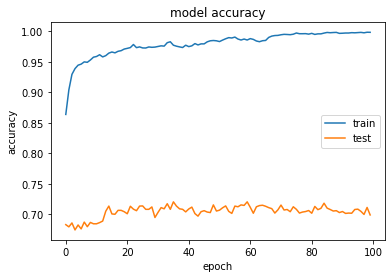

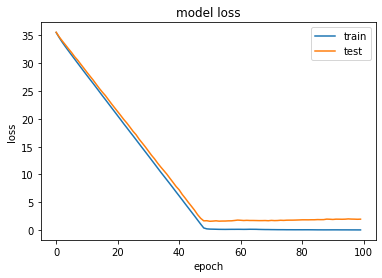

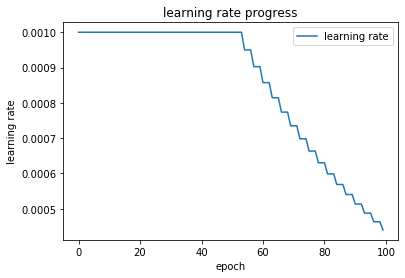

In [16]:
#print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
model = best_model
#model = load_model('best_model/'+model_name+'.h5')
print('*'*30+'BEST MODEL SUMMARY'+'*'*30)
model.summary()
model.compile(loss='sparse_categorical_crossentropy',optimizer=best_run['optimizer_choice'],metrics=['accuracy'])

checkpointer, call_reduce, callback_lr, callback_es, callback_csv = get_callback(early_stopping_count)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

callbacks_list = [checkpointer, call_reduce, callback_es, callback_csv, tensorboard]

history = model.fit([x_train1,x_train, x_train], y_train,batch_size=batch_size, epochs=training_epochs,
                    verbose=training_verbose, validation_data=([x_test1, x_test, x_test], y_test), callbacks=callbacks_list)

test_score, test_accuracy = best_model.evaluate([x_test1, x_test, x_test], y_test, batch_size=batch_size)
print('test_score: ', test_score, ' test_accuracy: ', test_accuracy)
draw_history()

In [17]:
class_names = ['BUY', 'SELL']


def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion Matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=10)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    #plt.figure(figsize = (10,10))
    plt.savefig('train_model/'+model_name+'.png', facecolor='yellowgreen',bbox_inches='tight', dpi=100)
    plt.show()

[[1030  518]
 [ 561 1475]]


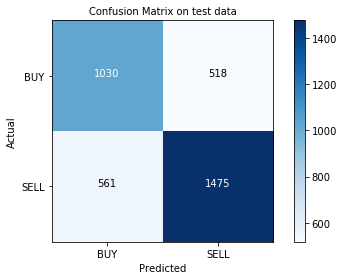

ROC_AUC_SCORE:  0.694917200976734


In [18]:
prediction_test = (np.argmax(model.predict([x_test1,x_test, x_test], batch_size=batch_size), axis=1))
actual_test = y_test
cnf_matrix = confusion_matrix(actual_test, prediction_test)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix on test data')
ROC_AUC_SCORE=(roc_auc_score(actual_test, prediction_test))
print('ROC_AUC_SCORE: ',ROC_AUC_SCORE)

In [19]:
x_predict1 = x_predict.reshape(x_predict.shape[0], 1, x_predict.shape[1], x_predict.shape[2]) 
forecast_last_batch =  model.predict([x_predict1,x_predict, x_predict], batch_size=batch_size)
future_prediction = np.argmax(forecast_last_batch,axis=1)[-forecast_period:]
future_probability = forecast_last_batch [-forecast_period:]

In [20]:
today = now.strftime("%d-%m-%Y")
nyse = mcal.get_calendar('NYSE') # NYSE Calendar
schedule_nyse = nyse.schedule(last_date, today)[0:(forecast_period+1)]
selected_date_range_from_last_date = list(pd.to_datetime(schedule_nyse.market_close.dt.to_pydatetime()).strftime('%m/%d/%Y'))
last_prediction_day = selected_date_range_from_last_date[-1]
last_prediction_day1 = (datetime.datetime.strptime(last_prediction_day, "%m/%d/%Y")+ timedelta(days=1)).strftime("%Y-%m-%d")

In [21]:
data = yf.download(ticker, start=last_date, end=last_prediction_day1)["Adj Close"]
data = data.pct_change() 
data[data > 0] = 1
data[data <= 0] = 0
data = data.dropna()
data=pd.DataFrame(data)
data.rename(columns = {'Adj Close':'actual'}, inplace = True)
data['sell probability'] = list(pd.DataFrame(future_probability)[0].values)
data['buy probability'] = list(pd.DataFrame(future_probability)[1].values)
data['prediction']=list(future_prediction)
data.loc[data['actual'] == data['prediction'], 'accuracy'] = 'correct'
data.loc[data['actual'] != data['prediction'], 'accuracy'] = 'incorrect'
build_path('prediction')
data.to_csv('prediction/'+model_name+'.csv')
print('*'*80)
print(data)
print('*'*80)
print('Prediction Accuracy :', len(data[data['accuracy']=='correct'])/len(data))

[*********************100%***********************]  1 of 1 completed
Directory  prediction  already exists
********************************************************************************
            actual  sell probability  buy probability  prediction   accuracy
Date                                                                        
2020-04-16     1.0          0.000982         0.999018           1    correct
2020-04-17     1.0          0.000778         0.999222           1    correct
2020-04-20     0.0          0.004699         0.995301           1  incorrect
2020-04-21     0.0          0.209713         0.790287           1  incorrect
2020-04-22     1.0          0.214680         0.785320           1    correct
2020-04-23     0.0          0.018073         0.981927           1  incorrect
2020-04-24     1.0          0.999993         0.000007           0  incorrect
********************************************************************************
Prediction Accuracy : 0.42857142857142